# Impact of different temporal variabilities on retrieving state parameters
### Applying EOLDAS on microwave data to retrieve SM, Tsoil and LAI using SCOPE and ``eoldas_ng``

#### Joris Timmermans  ``<j.timmermans@ucl.ac.uk>`` 

The aim of this notebook is to demonstrate the data assimilation by EOLDAS over the Speulderbos (the Netherlands) to predicte SM/LAI/Tsoil that were obtained through field measurements. 

# 0. Overview

This notebook shows the capabilty of the EOLDAS code to retrieve Component Temperatures. The Data input for this is:
* Brightness Temperatures estimated by LST + band31/32 emissivities from MOD11A1
* LAI from MCD15A2 (v005)
* Meteorological data from ECMWF: Ta, U, surface shortwave downwelling radiation (Rin),  surface shortwave downwelling radiation (Rli)

The Data output for this is:
* The maximum carboxilation capacity (Vcmo)
* Updated Leaf Area Index
* Component Temperatures (sunlit/shaded, leaf/soil)

#<img src="files/FlowchartOfProcessing.png">

#  1. Parameters

## 1.1 location 

In [513]:
# landcover                    = 'Farmland'
# datadir                      = '/home/ucfajti/Data/Fieldsites/Elbara/elbara_data/elbara_processed/'
# datadir_measurements         = '/home/ucfajti/Data/Fieldsites/Elbara/in_situ_data/'

lat                           = 52.2510
lon                           = 05.6899
el                            = 0.0

from IPython.display import IFrame
from IPython.core.display import display

# google_maps_url = "http://maps.google.com/maps?q=48.184543+11.213&ie=UTF8&t=h&z=18&output=embed&z=17"
google_maps_url = 'http://maps.google.com/maps?q=%7.5f' % lat + '+%7.5f' % lon +'&ie=UTF8&t=h&z=18&output=embed&z=17'
IFrame(google_maps_url,800,600)

# rapideye_dates[1] = (2009, 10, 4, 11, 0, 40, 320000)

## 1.2 Temporal 

In [514]:
import datetime
mindate                        = datetime.datetime(2016,10, 1,  0, 0, 0)      # 14 days 
maxdate                        = datetime.datetime(2016,10,30, 23,59,59)      # with both MW data and 1 rapid eye obs.

mindate                        = datetime.datetime(2015, 4, 1,  0, 0, 0)      # 14 days 
maxdate                        = datetime.datetime(2015, 6,30, 23,59,59)      # with both MW data and 1 rapid eye obs.


# for plotting purposes
datemin                       = datetime.datetime(2016, 10,  1)
datemax                       = datetime.datetime(2016, 11,  1)

datemin                       = datetime.datetime(2015,  4,  1)
datemax                       = datetime.datetime(2015,  7,  1)

## 1.3 Required python modules 

In [515]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from eoldas_ng import *
import copy
import glob
import datetime as dt
# from strongconstraint_utils6 import inverse_transform_cmem

In [516]:
def readmodisdata(fileroot, filetail, years):
    '''
    Read modis data from a text file.
    
    usage:
    data, dates = modisdata(fileroot, filetail, years)
    
    years is a list of years eg years = [2008, 2009]
    the modis files are in the format 
        fileroot year filetail
    eg if fileroot = "../MODIS_500m_"
    and filetail = "_rescaled.txt"
    modis data will look for the files:
    '../MODIS_500m_2008_descaled.txt'
    '../MODIS_500m_2009_descaled.txt'
    fileroot needs to include the path to the file (may be relative path).
    
    data is an numpy array the columns are:
    DoY QA QA_PASS SZA SAA VZA VAA RHO_B1 RHO_B2 RHO_B3 RHO_B4 RHO_B5 RHO_B6 RHO_B7
    Dates is a 1d numpy array containing datetime.date objects corresponding to DOY.
    '''
    dates = []
    datalist = []
    for year in years:
        fname = fileroot+str(year)+filetail #construct filename
        print fname
        dataset = np.loadtxt(fname, skiprows=0) #load file into an array
        datalist.append(dataset)
        days = dataset[:,0]
        
        dates += [(datetime.datetime(year, 1, 1,)+dt.timedelta(day-1)) for day in days]
    data = np.concatenate(datalist) #combine data from each file into a single array.
    
    return data, np.array(dates)

In [517]:
def readecmwfdata(fileroot, filetail, years):
    '''
    Read ecmwf data from a text file.
    
    usage:
    data, dates = ecmwfdata(fileroot, filetail, years)
    
    years is a list of years eg years = [2008, 2009]
    fileroot needs to include the path to the file (may be relative path).
    
    data is an numpy array the columns are:
    DoY Ta U Rin Rli
    Dates is a 1d numpy array containing datetime.date objects corresponding to DOY.
    '''
    dates = []
    datalist = []
    for year in years:
        fname = fileroot+str(year)+filetail #construct filename
        print fname
        dataset = np.loadtxt(fname, skiprows=0) #load file into an array
        datalist.append(dataset)
        days = dataset[:,0]
        
        dates += [(datetime.datetime(year, 1, 1,)+dt.timedelta(day-1)) for day in days]
    data = np.concatenate(datalist) #combine data from each file into a single array.
    
    return data, np.array(dates)

# 2. Simplifying Forward Model

* add simplification (biochemical_joris)
* add selection of parameters ->sensitivity analysis 
* 


# 3. Data


## 3.1 Read from observations data

### 3.1.2 Read from satellite observations

##### optical
Please note that the bands in the optical data are per sorted per band number. This means that this data is not sorted per wavelength (band 1&2 have higher wavelengths than band 3 and 4)

In [518]:
years                         = [2016,2017]
years                         = np.unique(np.arange(datemin.year,datemax.year+1,1))


modisfileroot                 = './MODIS_LAI_500m_test_pixels/brdf_52.25_005.68_'
modisfiletail                 = '_scaled.txt'


modisdata, modisdates_        = readmodisdata(modisfileroot, modisfiletail, years)
numdays                       = len(modisdates_)

./MODIS_LAI_500m_test_pixels/brdf_52.25_005.68_2015_scaled.txt


##### thermal

In [519]:
years                         = [2016,2017]
years                         = np.unique(np.arange(datemin.year,datemax.year+1,1))
modisfileroot_Tb              = './MODIS_LAI_500m_test_pixels/Tbright_52.25_005.68_'
modisfiletail_Tb              = '_scaled.txt'


modisdata_Tb, modisdates_Tb_   = readmodisdata(modisfileroot_Tb, modisfiletail_Tb, years)
numdays_Tb                     = len(modisdates_Tb_)

./MODIS_LAI_500m_test_pixels/Tbright_52.25_005.68_2015_scaled.txt


##### LAI

./MODIS_LAI_500m_test_pixels/LAI_52.25_005.68_2015_scaled.txt


<Container object of 3 artists>

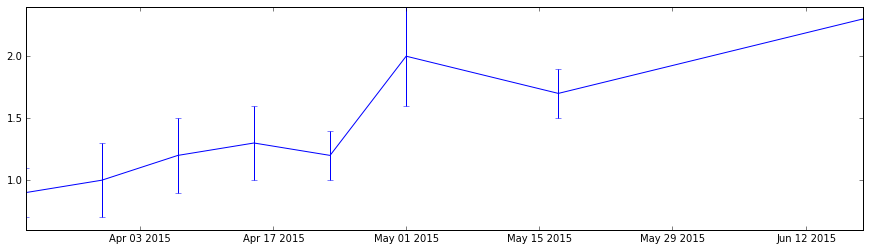

In [520]:
years                         = [2016,2017]
years                         = np.unique(np.arange(datemin.year,datemax.year+1,1))
modisfileroot_Tb              = './MODIS_LAI_500m_test_pixels/LAI_52.25_005.68_'
modisfiletail_Tb              = '_scaled.txt'


modisdata_LAI, modisdates_LAI_ = readmodisdata(modisfileroot_Tb, modisfiletail_Tb, years)
numdays_Tb                     = len(modisdates_Tb_)

plt.figure(figsize=[15,4])
plt.errorbar(modisdates_LAI_,modisdata_LAI[:,1], yerr=modisdata_LAI[:,2])

### 3.1.3 Read from Reanalysis

In [521]:
years                         = [2016]
years                         = np.unique(np.arange(datemin.year,datemax.year+1,1))

ecmwffileroot                 = './ECMWF_Meteorological_13km_test_pixels/MeteorologicalData_52.25_005.68_'
ecmwffiletail                 = '_descaled.txt'

ecmwfdata, ecmwfdates_        = readecmwfdata(ecmwffileroot, ecmwffiletail, years)

./ECMWF_Meteorological_13km_test_pixels/MeteorologicalData_52.25_005.68_2015_descaled.txt


## 3.2 Read from observations data

(array([ 24.,  51.]),
 array([ 10.  ,  11.75,  13.5 ]),
 <a list of 2 Patch objects>)

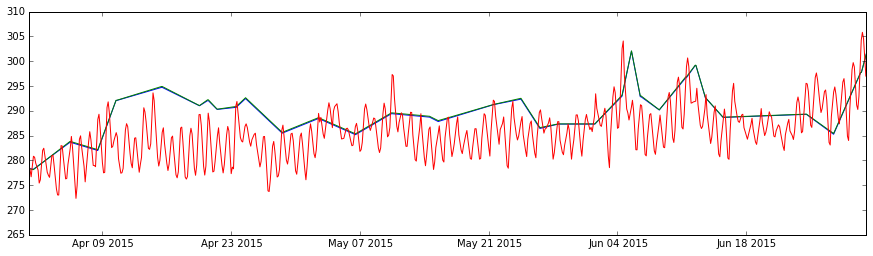

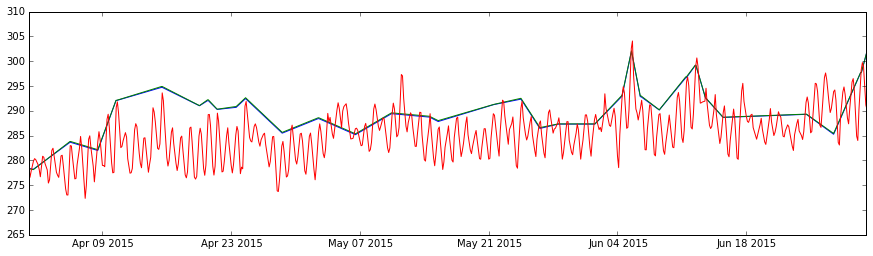

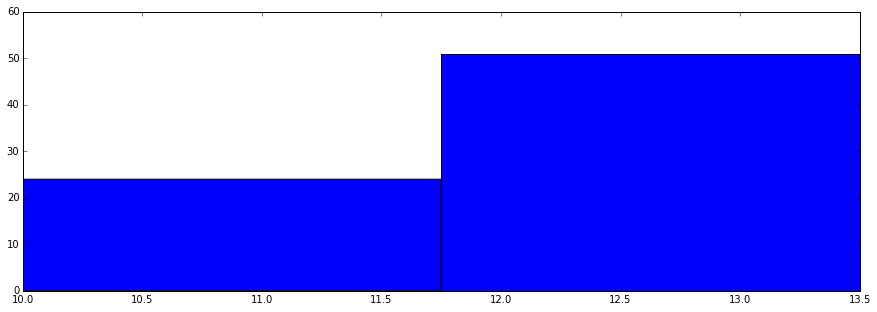

In [522]:
# after checking the collocation with the thermal observations it appears(!) that there is a day offset. This needs
# further investigation, but up to that point we simply apply an shift

plt.figure(figsize=[15,4])
plt.plot(modisdates_Tb_, modisdata_Tb[:,7:9])
plt.plot(ecmwfdates_,ecmwfdata[:,1])
plt.xlim([datetime.datetime(2015,4,1), datetime.datetime(2015,7,1) ])


ecmwfdates_                   = ecmwfdates_+ datetime.timedelta(1)

plt.figure(figsize=[15,4])
plt.plot(modisdates_Tb_, modisdata_Tb[:,7:9])
plt.plot(ecmwfdates_,ecmwfdata[:,1])
plt.xlim([datetime.datetime(2015,4,1), datetime.datetime(2015,7,1) ])

#label plots!

Tb_hour  = [day.hour + day.minute/60. for day in modisdates_Tb_]
# Tb_hours = np.round(np.array(Tb_hour)*2)/2
plt.figure(figsize=[15,5])
plt.hist(Tb_hours,2)
# plt.plot(modisdates_Tb_,Tb_hour,'o')

### 3.2.1 Temporal

In [523]:
#convert opt-observational dates to doy format
doy                            = []
for i in xrange(len(modisdates_)):
    dates2                     = modisdates_[i]    
    
    datenum_m                  = float(dates2.toordinal())*24*60 + float(dates2.hour)*60 + float(dates2.minute)
    datenum                    = datenum_m/24/60
    doy.append(datenum_m)    
doy_                            = np.array(doy)

# convert thermal-observational dates to doy format
doy_Tb                          = []
for i in xrange(len(modisdates_Tb_)):
    dates2                     = modisdates_Tb_[i]    
    
    datenum_m                  = float(dates2.toordinal())*24*60 + float(dates2.hour)*60 + float(dates2.minute)
    datenum                    = datenum_m/24/60
    doy_Tb.append(datenum_m)    
doy_Tb_                          = np.array(doy_Tb)

# convert meteorological- dates to doy format
doy_meteo                      = []
for i in xrange(len(ecmwfdates_)):
    dates2                     = ecmwfdates_[i]    
    
    datenum_m                  = float(dates2.toordinal())*24*60 + float(dates2.hour)*60 + float(dates2.minute)
    datenum                    = datenum_m/24/60
    doy_meteo.append(datenum_m)    
doy_meteo_                     = np.array(doy_meteo)


### 3.2.3 Reflectance-observations

In [524]:
doy            = doy_
state          = modisdata[:, 1]
pss            = modisdata[:, 2]

sza            = modisdata[:, 3]
vza            = modisdata[:, 5]
raa            = (modisdata[:, 6] - modisdata[:,4])
obs            = modisdata[:,7:]
obs_unc        = np.ones_like(obs)*0.01

# create filter 
# passer is used to select data that has a good quality control flag (qc=1)
# and that is within the date range we wish to use.
passer1        =  [qc==1                                  for qc,ob, day in zip(pss,obs, modisdates_)]
passer2        =  [day >= mindate and  (day < maxdate )    for qc,ob, day in zip(pss,obs, modisdates_)]
passer         =  np.array(passer1) & np.array(passer2)

# Filter the data
modisdates     = modisdates_[passer]
doy            = doy[passer]
sza            = sza[passer]
vza            = vza[passer]
raa            = raa[passer]

rho            = obs[passer,:].T
rho_unc        = obs_unc[passer,:].T

### 3.2.2 thermal-Observations

In [525]:
doy_Tb            = doy_Tb_
state_Tb          = modisdata_Tb[:, 1]
pss_Tb            = modisdata_Tb[:, 2]
sza_Tb            = modisdata_Tb[:, 3]
vza_Tb            = modisdata_Tb[:, 5]
raa_Tb            = (modisdata_Tb[:, 6] - modisdata_Tb[:,4])
obs_Tb            = modisdata_Tb[:,7:9]
obs_Tb_unc        = modisdata_Tb[:,9:11]


# create filter
# passer is used to select data that has a good quality control flag (qc=1)
# and that is within the date range we wish to use.
passer1           =  [qc ==1                                        for qc,ob, day in zip(pss_Tb,obs_Tb, modisdates_Tb_)]
passer2           =  [all(ob[0:1] >= 10.)  and  all(ob[0:1] < 400.) for qc,ob, day in zip(pss_Tb,obs_Tb, modisdates_Tb_)]
# passer3           =  [(day >= mindate)     and  (day < maxdate )    for qc,ob, day in zip(pss_Tb,obs_Tb, modisdates_Tb)]
passer_Tb         = np.array(passer1) & np.array(passer2)

# Filter the data
modisdates_Tb     = modisdates_Tb_[passer_Tb]
doy_Tb            = doy_Tb[passer_Tb]
sza_Tb            = sza_Tb[passer_Tb]
vza_Tb            = vza_Tb[passer_Tb]
raa_Tb            = raa_Tb[passer_Tb]
Tb                = obs_Tb[passer_Tb,:].T
Tb_unc            = obs_Tb_unc[passer_Tb,:].T

### 3.3.5 Meteorological Data

In [526]:
doy_meteo         = doy_meteo_
Ta                = ecmwfdata[:,1]
U                 = ecmwfdata[:,2]
Rin               = ecmwfdata[:,3]
Rli               = ecmwfdata[:,4]

# Filter the data
# passer            = np.array(())
passer_meteo      =  ~np.isnan(Ta) & ~np.isnan(U) & ~np.isnan(Rin ) & ~np.isnan(Rli)

# Filter the data
doy_meteo         =  doy_meteo_[passer_meteo]
ecmwfdates        =  ecmwfdates_[passer_meteo]
Ta                =  Ta[passer_meteo]
U                 =  U[passer_meteo]
Rin               =  Rin[passer_meteo]
Rli               =  Rli[passer_meteo]

## 3.4 Plot Data

### 3.4.1 Plot Observations

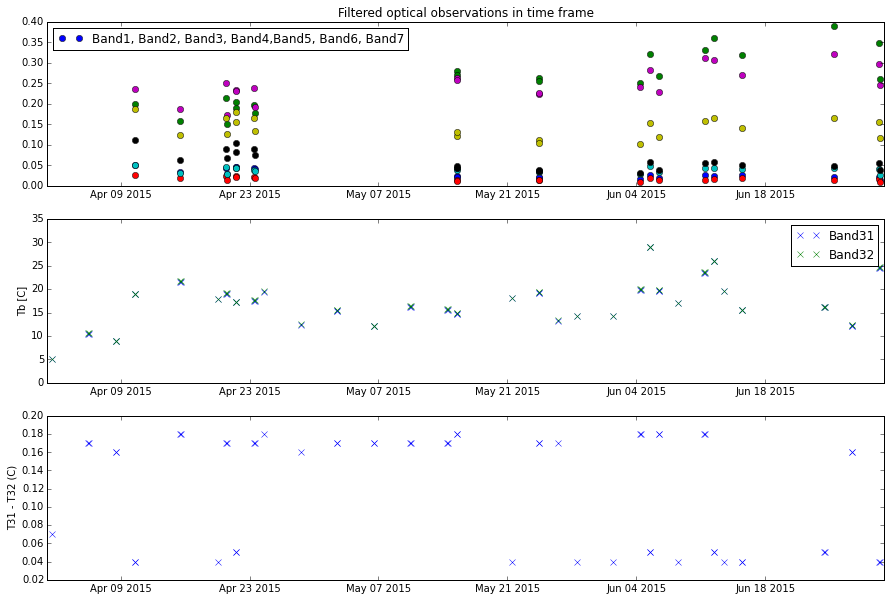

In [527]:
plt.figure(figsize=[15,10])
plt.subplot(3,1,1)
plt.plot( modisdates, rho.T,'o');
plt.title('Filtered optical observations in time frame')
plt.legend(['Band1, Band2, Band3, Band4,Band5, Band6, Band7'],loc=0);
plt.xlim(datemin, datemax);
plt.subplot(3,1,2)
plt.plot( modisdates_Tb, Tb.T - 273.15,'x');
plt.ylabel('Tb [C]')
plt.legend(['Band31', 'Band32'],loc=0);
plt.xlim(datemin, datemax);

plt.subplot(3,1,3)
plt.plot( modisdates_Tb, np.abs(Tb[0,:] - Tb[1,:]).T,'x');
plt.ylabel('T31 - T32 (C)')
plt.xlim(datemin, datemax);
plt.savefig('EOLDAS MODIS Observations.png')


# plt.ylim(150,320);
# plt.vlines(mindate,120,350,linestyles='dashed');
# plt.vlines(maxdate,120,350,linestyles='dashed');

# change symbols

### 3.4.2 Plot ECMWF data

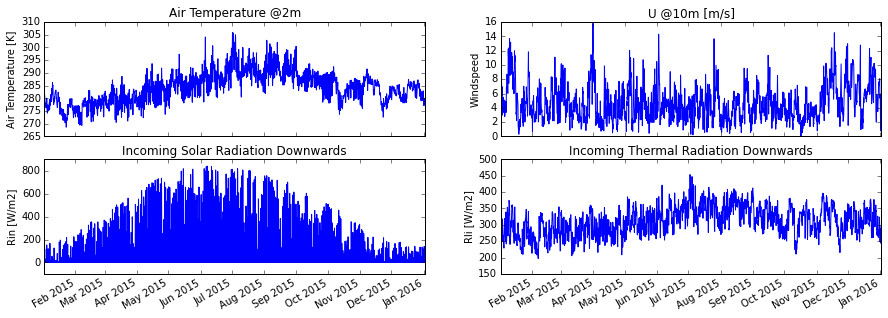

In [528]:
h1=plt.figure(figsize=[15,5])
plt.subplot(2,2,1)
plt.plot(ecmwfdates, Ta)
plt.title('Air Temperature @2m')
plt.ylabel('Air Temperature [K]')

plt.subplot(2,2,2)
plt.plot(ecmwfdates, U)
plt.title('U @10m [m/s]')
plt.ylabel('Windspeed')

plt.subplot(2,2,3)
plt.plot(ecmwfdates, Rin)
plt.title('Incoming Solar Radiation Downwards')
plt.ylabel('Rin [W/m2]')

plt.subplot(2,2,4)
plt.plot(ecmwfdates, Rli)
plt.title('Incoming Thermal Radiation Downwards')
plt.ylabel('Rli [W/m2]')
# plt.xlim([datetime.datetime(2015,1,1,0,0,0), datetime.datetime(2015,1,4,0,0,0)])

h1.autofmt_xdate()
# clear axis and make biggr

# 4. Setup data assimilation

## 4.0 load modules

In [529]:
import numpy as np
from strongconstraint_utils72 import StandardStateSCOPESAIL


from strongconstraint_utils72 import grab_prosail_emulators
from strongconstraint_utils72 import grab_scope_emulators

from strongconstraint_utils72 import ObservationOperatorNew

from collections import OrderedDict
from eoldas_ng import * # required to defined 'Fixed' 'Variable' 'Constant'

## 4.1 Prepare data

## 4.1.2 Subset Data

In [530]:
mindates                       = float(mindate.toordinal())*60*24 + float(mindate.hour)*60 + float(mindate.minute)
maxdates                       = float(maxdate.toordinal())*60*24 +float( maxdate.hour)*60 + float(maxdate.minute)

diffminT                       = doy - mindates
diffmaxT                       = doy - maxdates
diffminT_Tb                    = doy_Tb - mindates
diffmaxT_Tb                    = doy_Tb - maxdates

ns                             = np.argmin(np.abs(diffminT))
ne                             = np.argmin(np.abs(diffmaxT))+1
ns_Tb                           = np.argmin(np.abs(diffminT_Tb))
ne_Tb                           = np.argmin(np.abs(diffmaxT_Tb))+1

ns                              = np.min([np.max([ns,0]),len(doy)])
ne                              = np.min([np.max([ne,0]),len(doy)])
ns_Tb                           = np.min([np.max([ns,0]),len(doy_Tb)])
ne_Tb                           = np.min([np.max([ne,0]),len(doy_Tb)])

In [531]:
if len(rho_unc)>= (ne-ns):
    dates                           = modisdates[ns:ne]
    doy                             = doy[ns:ne]
    sza                             = sza[ns:ne]
    raa                             = raa[ns:ne]
    vza                             = vza[ns:ne]
    rho1                             = rho[:,ns:ne]
    rho_unc1                         = rho_unc[:,ns:ne]

In [532]:
if len(Tb_unc)>= (ne_Tb-ns_Tb):
    dates_Tb                        = modisdates_Tb[ns_Tb:ne_Tb]
    doy_Tb                          = doy_Tb[ns_Tb:ne_Tb]
    vza_Tb                          = vza_Tb[ns_Tb:ne_Tb]
    sza_Tb                          = sza_Tb[ns_Tb:ne_Tb]
    raa_Tb                          = raa_Tb[ns_Tb:ne_Tb]
    Tb                              = Tb[:,ns_Tb:ne_Tb]
    Tb_unc                          = Tb_unc[:,ns_Tb:ne_Tb]

## 4.2 Defining the state

The first thing to do is to **define the state**. This sets up the problem we're trying to solve. For simplicity, we'll use the *canned* PROSAIL state. The definition of the state basically means the definition of the following elements:

1. The state grid. This is the grid (in this case a vector) where the state is reported. In this experiment, we report the state daily over a year [NOTE: might need to change this to cover the growing season. If so, make sure the state goes from 1 on the first day of the state season to N, where N is the last day)

2. The state configuration ``state_config``. This is an (ordered) dictionary that for each variable in the state sets it to be either...
   * ``FIXED`` The default value of the parameter in the state will be used (the parameter is thus **not part** ofthe inference)
   * ``CONSTANT`` A single value will be substituted for this parameter over the entire state. As an example, it's similar to assuming that the parameter is "constant" over time.
   * ``VARIABLE`` We will infer this parameter for location in the state grid.
   
Although the PROSAIL standard class does offer some default values, in this case, we show how to set up other defaults. Note that internal representation of the default parameters is done in transformed coordinates, so the relevant transformer infrastructure needs to be used to convert from "real units" into "transformed units" (``eoldas_ng`` transformed units).

In [533]:
# First, we define the state grid, which in this case will report the state vector every day over the growing period
dt_m                           = 30*2*2                                   #min
startdays_m                    = np.round(mindates) -1
enddays_m                      = np.round(maxdates) + 1

numdays_m                      = enddays_m-startdays_m


state_grid                     = np.arange ( startdays_m, enddays_m , dt_m)
state_grid                     = np.round(state_grid)

state_grid_days = [mindate + datetime.timedelta(days=d/60/24) for d in (state_grid - state_grid[0])]
state_grid                     = state_grid.astype(int)

In [757]:
# The state_config needs to be an ordered dictionary, where the keys are stored in the order
# they are added to the dictionary 

state_config                   = OrderedDict ()

# scope parameters (subset of full parameter space)
state_config['Ta']             = FIXED
state_config['u']              = FIXED
state_config['Rin']            = FIXED
state_config['Rli']            = FIXED
state_config['lai']            = VARIABLE
state_config['emissivity_leaf']= VARIABLE #VARIABLE
state_config['emissivity_soil']= FIXED
state_config['Vcmo']           = VARIABLE #VARIABLE

# prospect parameters
state_config['n']              = FIXED
state_config['cab']            = FIXED #FIXED #VARIABLE
state_config['car']            = FIXED
state_config['cbrown']         = FIXED#FIXED
state_config['cw']             = VARIABLE #VARIABLE
state_config['cm']             = VARIABLE#FIXED #VARIABLE

state_config['ala']            = FIXED
state_config['bsoil']          = FIXED
state_config['psoil']          = FIXED

param_variable                 =  [k for k,v in state_config.iteritems() if v==3]
param_constant                 =  [k for k,v in state_config.iteritems() if v==2]

state                          =  StandardStateSCOPESAIL( state_config, state_grid, verbose=False)

Saving results to eoldas_retval_20170518_130358_lelantos.geog.ucl.ac.uk.pkl


In [758]:
# Define parameter transformations
transformations = {                
                'Rin': lambda x: x/1000., \
                'Rli': lambda x: x/1000., \
                'lai': lambda x: np.exp(-x/2.), \
                'cab': lambda x: np.exp ( -x/100. ), \
                'car': lambda x: np.exp ( -x/100. ), \
                'cw': lambda x: np.exp ( -50.*x ), \
                'cm': lambda x: np.exp ( -100.*x ), \
                'ala': lambda x: x/90. }
inv_transformations = {
                'Rin': lambda x: x*1000., \
                'Rli': lambda x: x*1000., \
                'lai': lambda x: -2.*np.log(x), \
                'cab': lambda x: -100*np.log ( x ), \
                'car': lambda x: -100*np.log( x ), \
                'cw': lambda x: (-1/50.)*np.log ( x ), \
                'cm': lambda x: (-1/100.)*np.log ( x ), \
                'ala': lambda x: 90.*x }

state.set_transformations ( transformations, inv_transformations )

## 4.3 Setup observation Operators

The MODIS data need to be interpreted by ``eoldas_ng``. This entails things like using the PROSAIL model **emulators** (Gomez-Dans and Lewis, 2015), spectral properties of the bands etc.

We simplify this by doing most things inside the ``observation_object`` function. This function returns an observational costraint (e.g. $J_{obs}(\vec{x})$) that can be used by the state.

### 4.3.1 Define observation operator

In [759]:
def thm_observation_object ( state, doy, Obs, vza, sza, raa, band_unc,emu_dir="./emulator4_transformedlai/" ):
    # representing MODIS thermal bands (31/32)
    ntrain                      = 400
    thresh                      = 1.-1.e-5
    thresh                      = 1.-1.e-4
#     thresh                      = 1. 

    # band characteristics
        
    MODISmin                   = np.array([10.78, 11.77])*1.e3;
    MODISmax                   = np.array([11.28, 12.27])*1.e3;
    wv                         = (MODISmax + MODISmin)/2
    bandwidth                  = (MODISmax - MODISmin)
    
    band_uncertainty            = band_unc
    quality                     = np.ones_like(doy)             # observations already filtered    
    band_pass                   = np.identity(2, dtype=np.bool) # already performed in SCOPE itself

    # load emulators
    emulators                   = grab_scope_emulators( vza, sza, raa, emulator_home=emu_dir,\
                                                  vza_q=5, sza_q=5, raa_q=5,ntrain=ntrain,thresh=thresh)

    # create objects
    mask                        = np.c_[ doy, quality, vza, sza,raa ]
    obs_obj                     = ObservationOperatorNew( state.state_grid, state, Obs, mask, \
                                    emulators, band_uncertainty, band_pass, \
                                    bandwidth )
    
    #perhaps to be put into emulators?
    obs_obj.selected_parameters = ['Ta','u','Rin','Rli','lai','emissivity_leaf','emissivity_soil','Vcmo']
    
     
        
    return obs_obj

In [760]:
def opt_observation_object ( state, doy,rho, vza, sza, raa, band_unc, emu_dir="./emulator4_transformedlai/prosail/" ):
    ntrain                      = 300
    thresh                      = 0.99
    
    # band characteristics
    # note that the band characteristics reflect that the data is bandsorted (not wavelength sorted)
    wv                          = np.arange ( 400, 2501 )
    modis_min                   = np.array( [ 620., 841, 459, 545, 1230, 1628, 2105] )
    modis_max                   = np.array( [ 670., 876, 479, 565, 1250, 1652, 2155] )
        
    bandwidth                   = modis_max - modis_min
    quality                     = np.ones_like(doy)             # observations already filtered            
    band_uncertainty            = band_unc
    
    
    band_pass                   = np.zeros((len(modis_min),len(wv)), dtype=np.bool)
    for i,v in enumerate(modis_min):
        band_pass[i,:]          = np.logical_and ( wv >= modis_min[i],  wv <= modis_max[i] )

    emulators                   = grab_prosail_emulators ( vza, sza, raa, emulator_home=emu_dir, \
                                                 vza_q=5, sza_q=5, raa_q=15,ntrain=ntrain,thresh=thresh)
    mask                        = np.c_[ doy, quality, vza, sza,raa ] 
    obs_obj                     = ObservationOperatorNew( state.state_grid, state, rho, mask, \
                                                        emulators, band_uncertainty, band_pass,  bandwidth )   
    
    obs_obj.selected_parameters= ['n', 'cab', 'car', 'cbrown', 'cw', 'cm', 'lai', 'ala', 'bsoil', 'psoil']
    obs_obj.wv                 = wv
    return obs_obj

### 4.3.2 load/create Emulators
Please note that this can be quite slow if the specific emulators have not been created before. First the SCOPE needs to be run in a forward mode for all the specific scenarios. Each scenario has an independent viewing geometry (SZA, VZA and RAA). Consequently if the more geometries a (temporal) dataset has the more emulators need to be created. 

If the sza goes from 0 degrees to 60 degrees, vza goes from 40 to 80 degrees, and raa goes from -240 to +240 degrees, than in total (considering step sizes of respectively 10, 10 and 30 degrees), 210 emulators should be created

In [761]:
doy                             = doy.astype(int)
doy_Tb                          = doy_Tb.astype(int)

angles = zip(sza_Tb,vza_Tb,raa_Tb)
angle_n = []
for i,angle in enumerate(angles):
    isza  = int(5 * round(float(angle[0])/5))
    ivza  = int(5 * round(float(angle[1])/5))
    iraa  = int(5 * round(float(angle[2])/5))
    
#     print isza, ivza, iraa
    angles[i] = [isza,ivza, iraa]
angles = np.array(angles)
# print angles

for angle in angles:
    emu_dir="./emulator4_transformedlai/" 
    strs = '%04.0f_' % angle[0] + '%04.0f_' % angle[1] + '%04.0f_' % angle[2] + 'scope.npz'
    files = glob.glob(emu_dir + strs)
    
    
    if len(files)<1:
        print strs

# vza_Tb

In [762]:
opt_observations             = opt_observation_object(state,doy,rho ,vza,sza,raa,rho_unc)

In [763]:
# i =1
# print 5*np.round(np.array(zip(sza_Tb[0:i],vza_Tb[0:i],raa_Tb[0:i]))/5)
# thm_observations             = thm_observation_object(state,doy_Tb[0:i],Tb[:,0:i] ,vza_Tb[0:i],sza_Tb[0:i],raa_Tb[0:i],Tb_unc[:,0:i])

# 15-05-2017 15:47
thm_observations             = thm_observation_object(state,doy_Tb,Tb ,vza_Tb,sza_Tb,raa_Tb,Tb_unc)

### Explain errors in training

In [764]:
# # thm_observations             = thm_observation_object(state,doy_Tb,Tb ,vza_Tb,sza_Tb,raa_Tb,Tb_unc)
# em_thm = thm_observations.emulators[tuple(thm_observations.sel_emu_keys[10])]
# em_opt = opt_observations.emulators[tuple(opt_observations.sel_emu_keys[10])]

# # plt.plot(em_thm.y_train[:,7], em_thm.X_train[:,1],'>')
# # plt.plot(em_thm.y_train[:,7], em_thm.X_train[:,0],'ro')
# # plt.plot(em_opt.hyperparams);
# # plt.plot(em_thm.hyperparams);

# # investigate behaviour of VCMO
# # print np.shape(em_opt.y_train)
# # print np.shape(em_opt.basis_functions)
# # print np.shape(em_opt.hyperparams)

# # plt.figure(figsize=[15,4])
# # plt.subplot(2,2,1)
# # plt.plot(em_opt.basis_functions[0,:].T);
# # plt.subplot(2,2,2)
# # plt.plot(np.abs(em_opt.hyperparams[:,0]))
# # plt.xlabel('Parameter number (+2)')

# # plt.subplot(2,2,3)
# # plt.plot(em_thm.basis_functions[0,:].T);
# # plt.subplot(2,2,4)
# # plt.plot(np.abs(em_thm.hyperparams[:,0]))
# # plt.xlabel('Parameter number (+2)')

# print em_thm.y_train[0,:].T
# # 
# # em_thm.y_train[0,0]

# xx_train  = copy.deepcopy(em_thm.y_train[0,:].T)
# xx_train[0]  = 20.
# xx_train[1]  = 5.
# xx_train[2]  = 0.6
# xx_train[3]  = 0.2
# xx_train[4]  = 0.5
# xx_train[5]  = 0.98
# xx_train[6]  = 0.95
# xx_train2[7] = 10.
# xx_train2 = copy.deepcopy(em_thm.y_train[0,:].T)
# xx_train2[0] = 20.
# xx_train2[1]  = 5.
# xx_train2[2]  = 0.6
# xx_train2[3]  = 0.2
# xx_train2[4]  = 0.5
# xx_train2[5]  = 0.98
# xx_train2[6]  = 0.95
# xx_train2[7] = 80.
# v,vv = em_thm.predict(xx_train)
# v2,vv = em_thm.predict(xx_train2)

# plt.plot(v)
# plt.plot(v2)

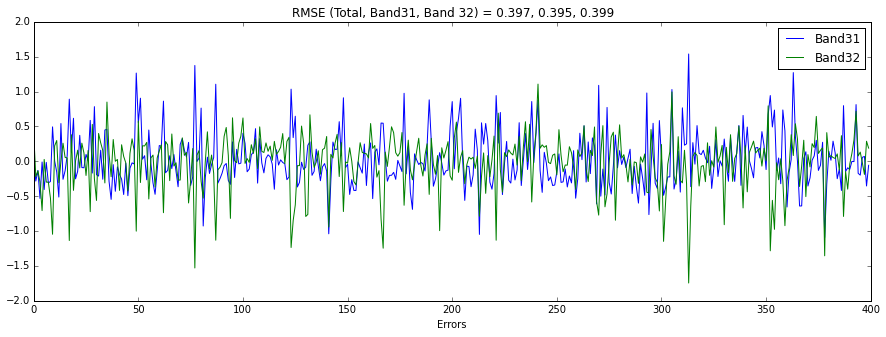

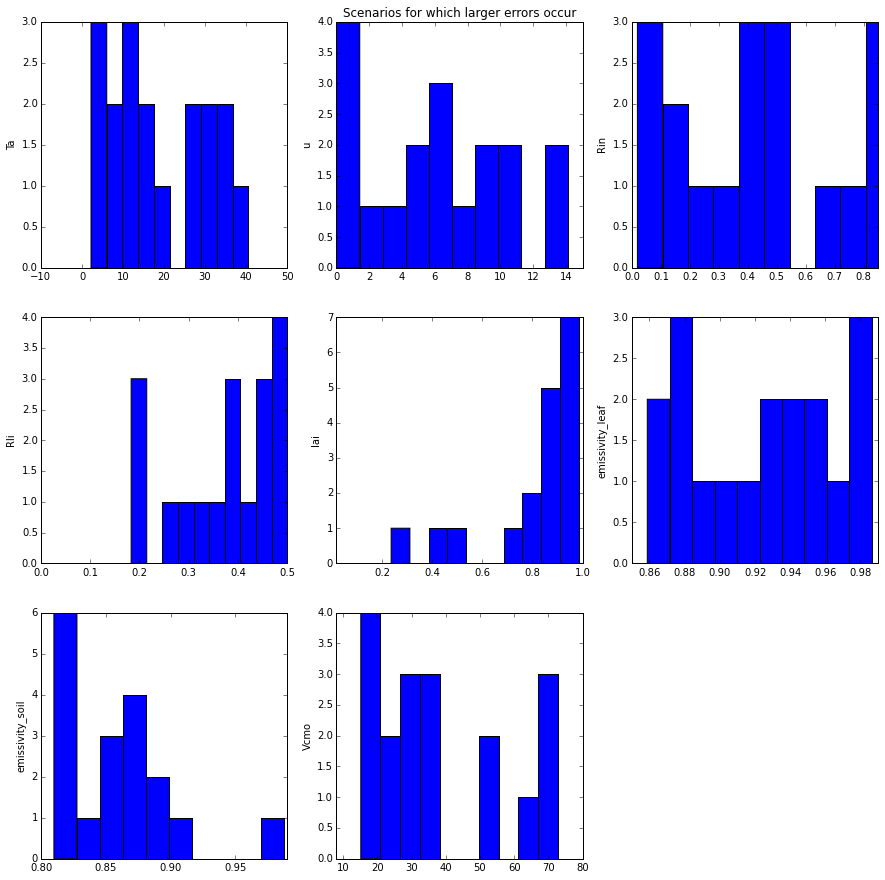

In [765]:
em_thm = thm_observations.emulators[50,40,55]

dv = []

for i in xrange(np.shape(em_thm.y_train)[0]):
    v,vv = em_thm.predict(em_thm.y_train[i,:].T)
    
    dv.append(  v - em_thm.X_train[i,:].T)
dv = np.array(dv)
RMSE_bands = np.sqrt(np.mean(dv**2, axis=0));
RMSE_full = np.sqrt(np.mean(dv**2));

I =  [ii for ii,i in enumerate(dv) if np.any(np.abs(i)>1.)]
scen_error = em_thm.y_train[I,:]

plt.figure(figsize=[15,5])
plt.plot(dv[:,:])
plt.xlabel('Errors')
plt.title('RMSE (Total, Band31, Band 32) = %4.3f, ' % RMSE_full + '%4.3f, ' % RMSE_bands[0] + '%4.3f ' % RMSE_bands[1])
plt.legend(['Band31','Band32'])
plt.savefig('Errors in Training.png')

# print zip(thm_observations.selected_parameters, scen_error[0,:])

Nc = 3
Nr = np.ceil(len(thm_observations.selected_parameters)/Nc)+1
plt.figure(figsize=[15,15])
for i,name in enumerate(thm_observations.selected_parameters):
    if i==2:
        plt.title('Scenarios for which larger errors occur')
    plt.subplot(Nr,Nc,i+1)
    plt.hist(scen_error[:,i]);
    plt.ylabel(name)
        
    if state.invtransformation_dict.has_key(name):
        V1 = state.transformation_dict[name](state.parameter_min[name])
        V2 = state.transformation_dict[name](state.parameter_max[name])
        
    else:
        V1 = state.parameter_min[name]
        V2 = state.parameter_max[name]

    plt.xlim([np.min([V1,V2]), np.max([V1,V2])])
plt.savefig('Errors in Training - explained.png')
# plt.subplot(Nr,Nc,i+1 +1)
# plt.ylabel('emissivity leaf- soil')
# plt.hist(scen_error[:,5]- scen_error[:,6])

# plt.subplot(Nr,Nc,i+1 +1)
# plt.ylabel('Rin- Rli')
# plt.hist(scen_error[:,3]- scen_error[:,2])

As we can see, the larger errors in the training occur specifically when LAI'>0.9 and Rli>300 Wm2. This error is caused because SCOPE has a hard time closing the energy balance in the case of low vegetation cover and high incoming thermal radiation. 

### Check if the observations fit within the simulation range 

#### optical

In [766]:
# according to Malenovsky et al, 2007, Applicability of the PROSPECT model for Norway spruce needles (Int. jour. RS)
state.default_values['n'] = 2.0
state.default_values['cab']= 70.0 #
state.default_values['car']= 10.0 #
state.default_values['cw'] = 0.05 #
state.default_values['cbrown'] = 0.0
state.default_values['psoil']= 0.7
state.default_values['bsoil']= 0.45

# pleate note that we have released the constraint on Cm, as fixing the value results in 
# a too low range for the observations to fit in: 
# state.default_values['cm'] = 0.025 


# band characteristics
# note that the band characteristics reflect that the data is bandsorted (not wavelength sorted)
wv                          = np.arange ( 400, 2501 )
modis_min                   = np.array( [ 620., 841, 459, 545, 1230, 1628, 2105] )
modis_max                   = np.array( [ 670., 876, 479, 565, 1250, 1652, 2155] )
Bandnr                      = np.array( [ 1, 2, 3, 4, 5, 6, 7] )
band_pass                   = np.zeros((len(modis_min),len(wv)), dtype=np.bool)
for i,v in enumerate(modis_min):
    band_pass[i,:]          = np.logical_and ( wv >= modis_min[i],  wv <= modis_max[i] )

In [767]:
em_opt = opt_observations.emulators[35,50,240]
# em_opt = opt_observations.emulators[30,10,-240]

In [768]:
# define the maximum-range for which the variable can vary
minv_ = []
maxv_ = []
for param in opt_observations.selected_parameters:
#     print param
    if np.any([p==param for p in param_variable]):
        minv = state.parameter_min[param]
        maxv = state.parameter_max[param]
        
    else:
        minv = state.default_values[param]
        maxv = state.default_values[param]
        
    if state.transformation_dict.has_key(param):
        minv = state.transformation_dict[param](minv)
        maxv = state.transformation_dict[param](maxv)
    
    minv_.append(minv)
    maxv_.append(maxv)
xx_max = np.array(maxv_)
xx_min = np.array(minv_)


print zip(opt_observations.selected_parameters, xx_min)
print zip(opt_observations.selected_parameters, xx_max)


# switch around min/max values (max Tb is obtained for low Vcmo and vice versa)
iss = np.array([i for i,name in enumerate(opt_observations.selected_parameters) if name=='cm'])[0]
xx_max[iss] = minv_[iss]    # lai 
xx_min[iss] = maxv_[iss]    # lai


# xx_max[1] = minv_[7]    # Vcmo
# xx_min[7] = maxv_[7]    # Vcmo

[('n', 2.0), ('cab', 0.49658530379140953), ('car', 0.90483741803595952), ('cbrown', 0.0), ('cw', 0.80654144017732687), ('cm', 0.8436648165963837), ('lai', 1.0), ('ala', 0.77777777777777779), ('bsoil', 0.45000000000000001), ('psoil', 0.69999999999999996)]
[('n', 2.0), ('cab', 0.49658530379140953), ('car', 0.90483741803595952), ('cbrown', 0.0), ('cw', 0.023167612235305019), ('cm', 0.036516173753740416), ('lai', 0.018315638888734179), ('ala', 0.77777777777777779), ('bsoil', 0.45000000000000001), ('psoil', 0.69999999999999996)]


In [769]:
# state.default_values['emissivity_leaf']

In [770]:
# collocate meteorological values with observation
output_min_ = []
output_max_ = []
for i,v in enumerate(doy_):
#     for ii,name in enumerate(opt_observations.selected_parameters):        
#         if state_config[name]==1:
#             # integrate FIXED values into simulations
#             xx_max[ii] = prospect[name][i]
#             xx_min[ii] = prospect[name][i]
    
    
    output_minn, doutput= em_opt.predict(xx_min)
    output_maxx, doutput= em_opt.predict(xx_max)
    
    # apply sensor sensitivity
    output_min= np.zeros_like(modis_min)
    output_max= np.zeros_like(modis_min)
    for iband in xrange(np.shape(band_pass)[0]):
        output_min[iband] = np.mean(output_minn[band_pass[iband,:]])
        output_max[iband] = np.mean(output_maxx[band_pass[iband,:]])
    
    
    output_min_.append(output_min)
    output_max_.append(output_max)
output_min_ = np.array(output_min_)
output_max_ = np.array(output_max_)

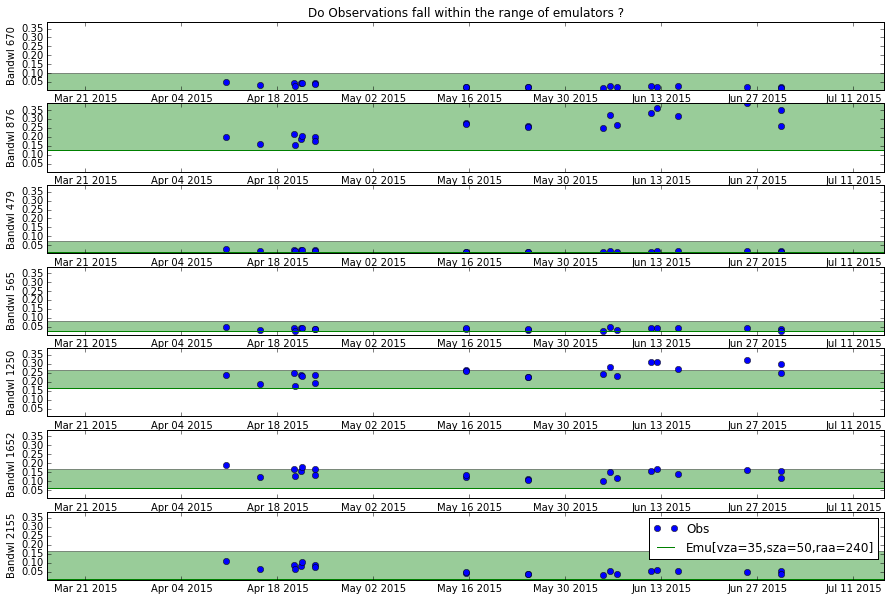

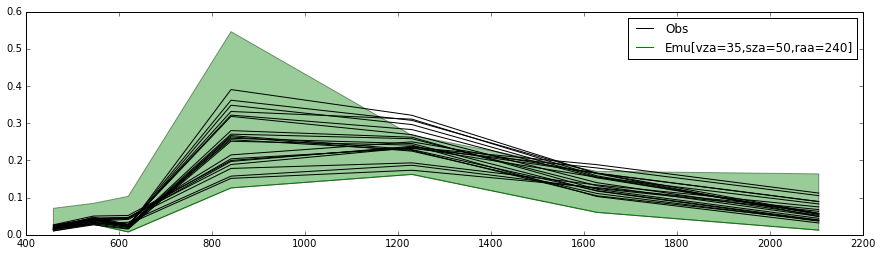

In [771]:
Nr = np.shape(rho)[0]
plt.figure(figsize=[15,10])
for i in xrange(Nr):    
    Vmin = ( np.min([output_min_[:,i], output_max_[:,i]], axis=0) )
    Vmax = ( np.max([output_min_[:,i], output_max_[:,i]], axis=0) )

    vmin = min(em_opt.X_train[:,i])
    vmax = max(em_opt.X_train[:,i])
    
    plt.subplot(Nr,1,i+1)
    plt.plot(modisdates,rho[i,:].T,'o')
    plt.plot(modisdates_,Vmin,'g')
    plt.fill_between(modisdates_,Vmin,Vmax,facecolor='g',alpha=0.4)
    plt.ylim([vmin,vmax])
    plt.ylabel('Bandwl %03.0f' % modis_max[i])
    
    if i==0:
        plt.title('Do Observations fall within the range of emulators ?')
    elif i==6:
        plt.legend(['Obs','Emu[vza=35,sza=50,raa=240]'],0)
            
plt.savefig('Optical Observations within range.png')

V1 = np.min([output_max_[0], output_min_[0]],axis=0)
V2 = np.max([output_max_[0], output_min_[0]],axis=0)

ibands = np.argsort(modis_min)
plt.figure(figsize=[15,4])
plt.plot(modis_min[ibands],rho[ibands,0],'k');
plt.plot(modis_min[ibands],V1[ibands],'g-')
plt.plot(modis_min[ibands],rho[ibands,1:],'k');
plt.fill_between(modis_min[ibands],V1[ibands],V2[ibands],facecolor='g',alpha=0.4)
plt.legend(['Obs','Emu[vza=35,sza=50,raa=240]'],0)
plt.savefig('Optical Observations within range -b.png')

#### thermal

In [772]:
em_thm = thm_observations.emulators[45,0,-260]
em_thm = thm_observations.emulators[50,40,55]

In [773]:
# state.default_values['emuissivity_leaf'] = 0.92
# state.default_values['emuissivity_soil'] = 0.90
# define the maximum-range for which the variable can vary
minv_ = []
maxv_ = []
for param in thm_observations.selected_parameters:
#     print param
    if np.any([p==param for p in param_variable]):
        minv = state.parameter_min[param]
        maxv = state.parameter_max[param]
        
    else:
        minv = state.default_values[param]
        maxv = state.default_values[param]
        
    if state.transformation_dict.has_key(param):
        minv = state.transformation_dict[param](minv)
        maxv = state.transformation_dict[param](maxv)
    
    minv_.append(minv)
    maxv_.append(maxv)
xx_max = np.array(maxv_)
xx_min = np.array(minv_)


# print zip(thm_observations.selected_parameters, xx_max)

# switch around min/max values (max Tb is obtained for low Vcmo and vice versa)
xx_max[4] = minv_[4]    # lai 
xx_min[4] = maxv_[4]    # lai


xx_max[7] = minv_[7]    # Vcmo
xx_min[7] = maxv_[7]    # Vcmo


print xx_max
print xx_min

[ 20.     2.     0.45   0.25   1.     0.99   0.95   8.  ]
[  2.00000000e+01   2.00000000e+00   4.50000000e-01   2.50000000e-01
   1.83156389e-02   8.50000000e-01   9.50000000e-01   8.00000000e+01]


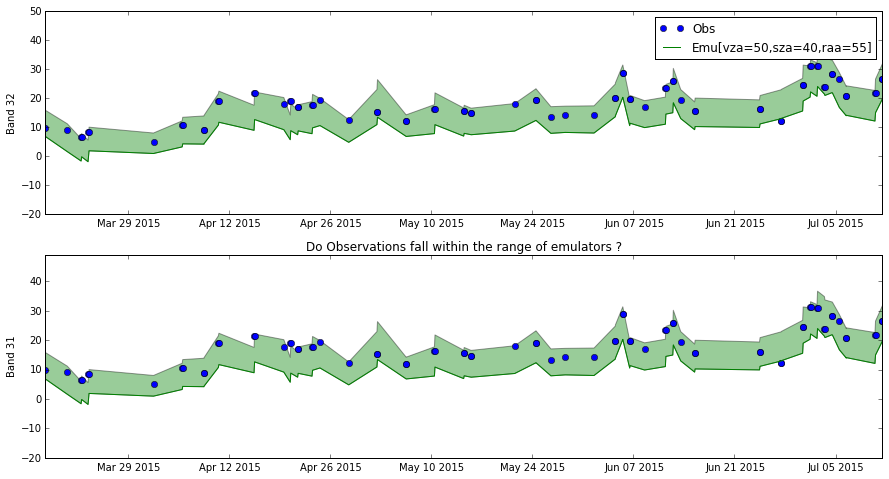

In [774]:
# collocate meteorological values with observation
meteo = OrderedDict()
meteo['Ta'] = np.interp(doy_Tb,doy_meteo,Ta - 273.15)
meteo['u'] = np.interp(doy_Tb,doy_meteo,U)
meteo['Rin'] = np.interp(doy_Tb,doy_meteo,Rin/1000)
meteo['Rli'] = np.interp(doy_Tb,doy_meteo,Rli/1000)

        
output_min_ = []
output_max_ = []
for i,v in enumerate(doy_Tb):
    for ii,name in enumerate(thm_observations.selected_parameters):
        
        if state_config[name]==1 and meteo.has_key(name):
            # integrate FIXED meteorological values into simulations
            xx_max[ii] = meteo[name][i]
            xx_min[ii] = meteo[name][i]
    
    
    output_min, doutput= em_thm.predict(xx_min)
    output_max, doutput= em_thm.predict(xx_max)
    
    output_min_.append(output_min)
    output_max_.append(output_max)
output_min_ = np.array(output_min_)
output_max_ = np.array(output_max_)


Nr = np.shape(Tb)[0]
plt.figure(figsize=[15,8])
for i in xrange(Nr):    
    Vmin = ( np.min([output_min_[:,i], output_max_[:,i]], axis=0) )
    Vmax = ( np.max([output_min_[:,i], output_max_[:,i]], axis=0) )
    
    vmin = min(em_thm.X_train[:,i])
    vmax = max(em_thm.X_train[:,i])
    
    plt.subplot(Nr,1,i)
    plt.plot(modisdates_Tb,Tb[i,:].T-273.15,'o')
    plt.plot(modisdates_Tb,Vmin,'g')
    plt.fill_between(modisdates_Tb,Vmin,Vmax,facecolor='g',alpha=0.4)
    plt.ylim([vmin,vmax])
    if i==0:
        plt.ylabel('Band 31')
        plt.title('Do Observations fall within the range of emulators ?')
    elif i==1:
        plt.ylabel('Band 32')
        plt.legend(['Obs','Emu[vza=50,sza=40,raa=55]'],0)
        
    
    
plt.savefig('Observations within range (with only Vcmo.png')          
# plt.savefig('Observations within range (with only LAI and Vcmo).png')
# plt.savefig('Observations within range (with only LAI and Vcmo and leaf emissivity).png')

# xx_min-xx_max

## 4.4 Setting up the prior

We can now set up the prior constraint,  Broadly, this constraint encodes the following

$$
J_{prior}(\vec{x}) = -\frac{1}{2}\left[ \vec{x} - \vec{\mu}_{x}\right]^{\top}\mathbf{C}_{prior}^{-1}\left[ \vec{x} - \vec{\mu}_{x}\right]
$$

Note that the definition of the prior mean $\vec{\mu}_x$ and covariance is assumed to be in **transformed coordinates**

The definition of ``mu_prior`` and ``prior_inv_cov`` is then passed to the ``Prior`` class creator.

as we are working in transformed values, it is necessary to give the uncertainties also in transformed units. This is done as follows (in case of standard deviation) in the case of z=f(x,y):

$$
{\Delta}z =  \sqrt{ (\frac{{\delta}f}{{\delta}x})^2{\Delta}x^2 + (\frac{{\delta}f}{{\delta}y})^2{\Delta}y^2 } 
$$

for example: if we know LAI (with a mean value of 1. m2/m2) has a uncertainty of 0.3 m2/m2 and the transformation is exp(-x/2), than $$\frac{{\delta}f}{{\delta}x} = -0.5*exp(-x/2) $$, and consequently $$ {\Delta}z = 0.0905 $$ 

In [775]:
doy_LAI    = [float(date.toordinal())*60*24 +float(date.hour)*60 + float(date.minute) for date in modisdates_LAI_]
LAI        = modisdata_LAI[:,1]

LAIi       = np.interp(state_grid,doy_LAI,LAI)
LAIi_inv   = state.transformation_dict['lai'](LAIi)
# modisdates_LAI_,modisdata_LAI[:,1], yerr=modisdata_LAI[:,2]

In [806]:
import scipy.sparse as sp
# When we choose lower values for prior_inv_cov2 the uncertainty for the apriori values decreases (and consequenlty
# it forces the data-assimilation to be closer to the apriori values). When we set these values for prior_inv_cov2
# higher the uncertainty on the apriori values increases (and consequently the data-assimilation will be more
# related to the observations (and  start-position, in case there are no observations).
                  

# tranformed values required!
mu_prior                       = OrderedDict ()


mu_prior['Ta']                 = np.array([20.])
mu_prior['u']                  = np.array([5.])
mu_prior['Rin']                = np.array([500./1000])
mu_prior['Rli']                = np.array([250./1000])
mu_prior["lai"]                = np.array([0.13])
mu_prior["lai"]                = np.array(LAIi_inv)
mu_prior["emissivity_leaf"]    = np.array([0.98])
mu_prior["emissivity_soil"]    = np.array([0.95])
mu_prior["Vcmo"]               = np.array([30.])

mu_prior["n"]                  = np.array([1.8])
mu_prior["cab"]                = np.array([0.6])
mu_prior["car"]                = np.array([0.97])
mu_prior['cbrown']             = np.array([0.2])
mu_prior['cw']                 = np.array([0.60])
mu_prior['cm']                 = np.array([0.5])

mu_prior['ala']                = np.array([0.5])
mu_prior['bsoil']              = np.array([1.]) 
mu_prior['psoil']              = np.array([0.5])

std_prior                      = OrderedDict ()
std_prior['Ta']                = np.array([0.3])
std_prior['u']                 = np.array([0.3])
std_prior['Rin']               = np.array([0.3])
std_prior['Rli']               = np.array([0.3])
std_prior["lai"]               = np.array([0.1]) #0.01
std_prior["emissivity_leaf"]   = np.array([0.1]) #0.01
std_prior["emissivity_soil"]   = np.array([0.1])
std_prior["Vcmo"]              = np.array([40.00]) # too strict!.. Vcmo changes from 5-80


std_prior["n"]                 = np.array([0.3])
std_prior["cab"]               = np.array([0.3])
std_prior["car"]               = np.array([0.3])
std_prior['cbrown']            = np.array([0.3])
std_prior['cw']                = np.array([0.3])
std_prior['cm']                = np.array([0.3])
std_prior['ala']               = np.array([0.3])
std_prior['bsoil']             = np.array([0.3])
std_prior['psoil']             = np.array([0.3])

In [807]:
nelems_max                     = 0
for param in state.parameter_min.iterkeys():
    nelems_max = np.max([len(std_prior[param]), nelems_max])
# print nelems_max
    


prior_inv_cov = OrderedDict ()
for param in state.parameter_min.iterkeys():
    #mu_prior[param] = np.array([state.default_values[param]])
    prior_inv_cov[param]       = 1/std_prior[param]**2
    

I = np.linspace(1,1,nelems_max)
ic = []
mu2 = []
for param,typo in state_config.iteritems():
    if typo==VARIABLE:
        ic.append(I*std_prior[param])
        mu2.append(I*mu_prior[param])
ic = np.array(ic)
mu = np.array(mu2)
ic = ic.flatten()
mu = mu.flatten()
    
    
try:
    ic = sp.diags(ic,0)
    
    # mu = sp.diags(mu,0)

    mu_prior2      = mu
    prior_inv_cov2 = ic



    # mu_prior['lai']=LAI_prior_inv
    prior                          = Prior ( mu_prior2, prior_inv_cov2)
except:
    prior                          = Prior ( mu_prior, prior_inv_cov)
    print 1

In [808]:
I = np.linspace(1,1,nelems_max)
ic = []
mu2 = []
for param,typo in state_config.iteritems():
    if typo==VARIABLE:
        mu2.append(I*mu_prior[param])
        VV = I*prior_inv_cov[param]

        ic.append(VV)

if nelems_max>1:
    # dynamic uncertainties
    ic = np.array(ic)
    mu = np.array(mu2)
    ic = ic.flatten()
    mu = mu.flatten()
    
    ic_diag = sp.diags(ic,0)
    
    mu_prior2      = mu
    prior_inv_cov2 = ic_diag

    print 'dynamic uncertainties'
    prior                          = Prior ( mu_prior2, prior_inv_cov2)
else: 
    #static uncertainties
    print 'static uncertainties'
    prior                          = Prior ( mu_prior, prior_inv_cov)

static uncertainties


## 4.5 Temporal regularisation

Temporal regularisation (Lewis et al., 2012) is a powerful bit of prior information. Critically, you need to specify to which parameters (defined as ``VARIABLE``) you will apply it, as well as the degree of regularisation. An example below, which applies the same regularisation to Cab, Cw:

In [809]:
gamma_hf                       = 10**3.5 # for temperatures?
gamma_lf                       = 10**7.0 # for leaf traits
# gamma_lf                       = 10**6.0 # for leaf traits

temporal                       = TemporalSmoother ( state_grid, [gamma_lf, gamma_lf, gamma_lf, gamma_lf, gamma_lf],
                                 required_params=['lai','emissivity_leaf', 'emissivity_soil','Vcmo','cm'])

# 5. Data assimilation 


## 5.1  starting values

In [810]:
N = state.state_grid.shape

#Starting values 
x_dict = dict()
for param in param_variable:
    # obtain real values
    if state.invtransformation_dict.has_key(param):
        meanv = state.invtransformation_dict[param](mu_prior[param])
    else:
        meanv = mu_prior[param]
    
    # pertube real values
    maxv          = state.parameter_max[param]
    minv          = state.parameter_min[param]
    rangev        = (maxv-minv)/2
    
    randoms       = 1-2*np.random.random_sample(N)
    V             = meanv + rangev*randoms*0.1
    
    # transform back to transformed values (required)
    if state.transformation_dict.has_key(param):
        V        = state.transformation_dict[param](V)
    else:
        V        = V
    
    
    x_dict[param] = V

## 5.1 Meteorological input parameters

In [811]:
Tai   = np.interp(state_grid,doy_meteo,Ta - 273.15)
Ui    = np.interp(state_grid,doy_meteo,U)
Rini  = np.interp(state_grid,doy_meteo,Rin)
Rlii  = np.interp(state_grid,doy_meteo,Rli)


state.default_values['Ta'] = Tai 
state.default_values['u'] = Ui   
state.default_values['Rin'] = Rini
state.default_values['Rli'] = Rlii

# print state.default_values['Ta']

# print state_opt.default_values['Ta']
# print state_opt.default_values['u']
# state_opt.default_values['Rin']=450.
# state_opt.default_values['Rli']=250.

## 5.2 Running EOLDAS

### 5.2.1 with only optical operators

In [812]:
state_opt0 = copy.deepcopy(state)

state_opt0.add_operator ( "Prior", prior)
state_opt0.add_operator ("Optical observations", opt_observations)
# state_opt0.add_operator ("Thermal observations", thm_observations)
# state_opt0.add_operator ("regularisation", temporal )

state_opt0.default_values['cab'] = 70
state_opt0.default_values['cw']=0.02

In [813]:
state_opt0.optimisation_options['maxiter']=1500# 1500 #500


import datetime

In [814]:
t1 = datetime.datetime.now()

retrieved_value_opt0,xx              =  state_opt0.optimize ( x0=x_dict, do_unc=False)


t2 = datetime.datetime.now()
deltat = ((t2-t1).total_seconds())/60
print 'Simulation time = %4.3f [min]' % deltat

Simulation time = 0.269 [min]


(0, 5)

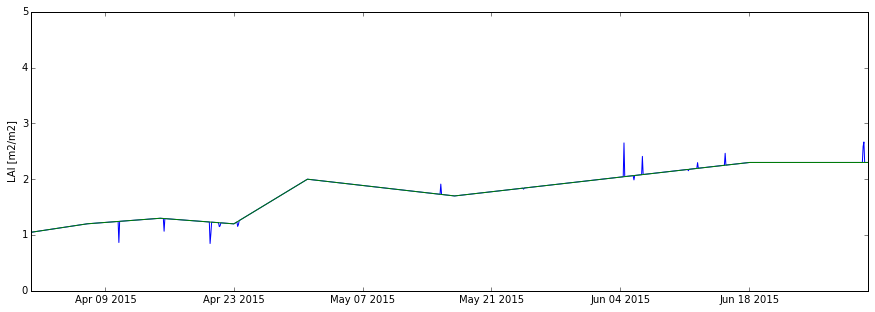

In [815]:
plt.figure(figsize=[15,5])
plt.plot(state_grid_days,retrieved_value_opt0['real_map']['lai'])
plt.plot(state_grid_days,LAIi)
plt.ylabel('LAI [m2/m2]')
plt.ylim([0,5])

### 5.2.1 with only thermal operators

In [816]:
state_thm = copy.deepcopy(state)

state_thm.add_operator ( "Prior", prior)
# state_opt.add_operator ("Optical observations", opt_observations)
state_thm.add_operator ("Thermal observations", thm_observations)
state_thm.add_operator ("regularisation", temporal )

In [817]:
state_thm.optimisation_options['maxiter']=2500# 1500 #500

In [818]:
t1 = datetime.datetime.now()

retrieved_value_thm,xx              =  state_thm.optimize ( x0=x_dict, do_unc=True)


t2 = datetime.datetime.now()
deltat = ((t2-t1).total_seconds())/60
print 'Simulation time = %4.3f [min]' % deltat

Simulation time = 3.387 [min]


In [819]:
# observations
# doy_meas                           = rapideye_dates

import datetime
# retrieved LAI

doy_retr                           = state_grid_days
lai                                = np.array(retrieved_value_thm['real_map']['lai'])
Cdm                                = np.array(retrieved_value_thm['real_map']['cm'])*np.ones_like(lai)
Vcmo                               = retrieved_value_thm['real_map']['Vcmo']*np.ones_like(lai)
emissivity_leaf                    = retrieved_value_thm['real_map']['emissivity_leaf']*np.ones_like(lai)
emissivity_soil                    = retrieved_value_thm['real_map']['emissivity_soil']*np.ones_like(lai)


param_variable

['lai', 'emissivity_leaf', 'Vcmo', 'cw', 'cm']

0 lai
1 emissivity_leaf
2 Vcmo
3 cw
4 cm
5 Ta
6 u
7 Rin
8 Rli


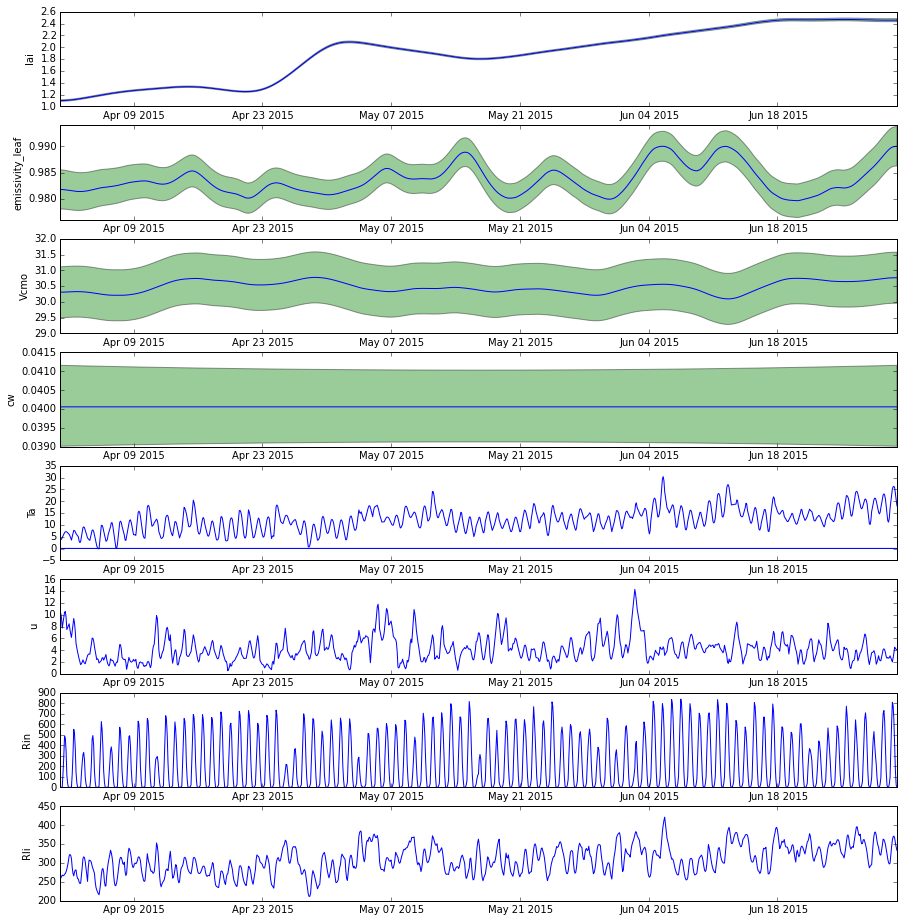

In [830]:
param_meteo = [name for name in meteo.iterkeys()]

Nr_plots = (len(param_variable) + len(param_meteo))*1.
Nc = 1.
Nr = np.ceil(Nr_plots/Nc)+1

# print Nr
h1 = plt.figure(figsize=[15,20])
for i,name in enumerate(param_variable):
    print i,name
    V = retrieved_value_thm['real_map'][name]
    Q25 = retrieved_value_thm['real_ci25pc'][name]
    Q75 = retrieved_value_thm['real_ci75pc'][name]
    minV = state_thm.parameter_min[name]
    maxV = state_thm.parameter_max[name]
    
    plt.subplot(Nr,Nc,i+1)
    plt.plot(state_grid_days,V)
    plt.fill_between(state_grid_days,Q25,Q75,facecolor='g',alpha=0.4)
    plt.ylabel(name)
    

for i2,name in enumerate(param_meteo):
    print i2+i+1,name
    V = retrieved_value_thm['real_map'][name]
    
    
    plt.subplot(Nr,Nc,(i2+i+1))
    plt.plot(state_grid_days,V,'b')
    plt.ylabel(name)
    
# h1.autofmt_xdate()
plt.savefig('EOLDAS Retrieved Parameters.png')

### Run SCOPE on retrieved parameters

In [825]:
import solar_utils
location                                    = [lat,lon,el]
szai                                        = []
for day in state_grid_days:
#     print datetime
    datetim                                 = [day.year,day.month,day.day,day.hour,day.minute,day.second]
    weather                                 = [1000,40] # not really relevent for zenith-angle calculation
    
    (angles, airmass)                       = solar_utils.solposAM(location, datetim, weather)
    
    zenith, azimuth                         = angles
    zenith                                  = np.min([zenith,89])
    szai.append(zenith)

vzai                                        = np.zeros_like(szai)
raai                                        = np.zeros_like(szai)

In [826]:
from SCOPE_tools import SCOPE
print 'initialize SCOPE'
scope_model                                 =   SCOPE()
do_scope_fwd_model                          =   scope_model.run_model

# specify height of vegetation (either 2 or 50 m).
scope_model.Input_transformed['hc']         =   50.
# specify reference heights according to ECMWF (defined as negative to be relative to vegetation height)
scope_model.matlab.put('zm',-10.)
scope_model.matlab.put('zh',-2.)
scope_model.matlab.eval('SCOPE_translate_bck')

# Define global dataset of parameters used in scope
Input_transformed                           = scope_model.Input_transformed
input_parameters                            = [name  for name,value in Input_transformed.iteritems() if not(name=='tto' or  name =='tts' or name=='psi')]
input_values_transformed                    = [value for name,value in Input_transformed.iteritems() if not(name=='tto' or  name =='tts' or name=='psi')]
input_dict_transformed                      = dict(zip(input_parameters,input_values_transformed))

input_parameters_transformed_default        = copy.deepcopy(input_values_transformed)
# print 'run normal'
# output = scope_model.run_model(input_values_transformed, szai[0], vza[0], raa[0])

initialize SCOPE


In [827]:
len(SCOPE_input)
output = scope_model.run_model(input_values_transformed, szai[0], vza[0], raa[0])

In [828]:
# Define inputs for the model
# dummy = np.ones(len(state_grid_days))
lai_inv         = retrieved_value_thm['transformed_map']['lai'] 
emissivity_soil = retrieved_value_thm['transformed_map']['emissivity_soil']* np.ones_like(lai)
emissivity_leaf = retrieved_value_thm['transformed_map']['emissivity_leaf']* np.ones_like(lai)
Vcmo            = retrieved_value_thm['transformed_map']['Vcmo']* np.ones_like(lai)


parameters                                  = ['Ta',   'u',   'Rin',       'Rli',        'lai', 'emissivity_leaf', 'emissivity_soil', 'Vcmo']
SCOPE_input_transformed                     = zip(Tai,Ui,Rini/1000.,Rlii/1000., lai_inv, emissivity_leaf, emissivity_soil, Vcmo)


# specifcy sorting
Isort                                       =   np.zeros_like(SCOPE_input_transformed[0]).astype('int')
for i1,name1 in enumerate(parameters):
    for i2,name2 in enumerate(input_parameters):
        if name1==name2:
            Isort[i1]                       =   i2
            

# output = scope_model.run_model(SCOPE_input_transformed[0], szai[0], vza[0], raa[0])
for i,name in enumerate(input_parameters):
    v = xx_transformed[i]
    diff = xx_transformed[i]-input_parameters_transformed_default[i]
    try:
        if np.any(diff<>0.):
            print name,v, diff
    except:
        a=1

# rza
# output = scope_model.run_model(xx_transformed, sza, vza, raa)

Ta 18.0477255556 -1.95227444444
u 4.11511669444 2.11511669444
Rin 0.000181756222222 -0.599818243778
Rli 0.333315551667 0.0333155516667
emissivity_leaf 0.980000653966 6.53966393815e-07
emissivity_soil 0.95 0.01
Vcmo 28.4474739328 -1.55252606718
lai 0.316694839426 0.0935646792776


In [470]:
# Run the model
Output =[]
counter =0
Nruns = len(SCOPE_input_transformed)*1.
print '%2.0f %%' % 0
for i,scope_input_transformed in enumerate(SCOPE_input_transformed):    
    # update parameters of global dataset with values from subset
    # print 'update input'
#     xx_s                                        =   SCOPE_input[i]
    xx_transformed                              =   copy.deepcopy(input_values_transformed)
    for i1,i2 in enumerate(Isort):
        xx_transformed[i2]                      =   scope_input_transformed[i1]


    # print 'run model'
    output = scope_model.run_model(xx_transformed, szai[i], vzai[i], raai[i])

    
    # print 'store output'
    Output.append ( output)

    # print 'status'
    counter = counter +1
    if counter==20:
        print '%2.0f %%' % (i/Nruns*100.)
        counter =0
        
print '%2.0f %%' % (i/Nruns*100.)

 0 %
 2 %
 4 %
 5 %
 7 %
 9 %
11 %
13 %
15 %
16 %
18 %
20 %
22 %
24 %
26 %
27 %
29 %
31 %
33 %
35 %
37 %
38 %
40 %
42 %
44 %
46 %
47 %
49 %
51 %
53 %
55 %
57 %
58 %
60 %
62 %
64 %
66 %
68 %
69 %
71 %
73 %
75 %
77 %
79 %
80 %
82 %
84 %
86 %
88 %
90 %
91 %
93 %
95 %
97 %
99 %
100 %


In [471]:
Tch = []
Tcu = []
Tsh = []
Tsu = []

for output in Output:
    Tch.append(output['Tch'])
    Tcu.append(np.mean(np.mean(output['Tcu'],axis=1),axis=0))

    Tsh.append(output['Ts'][0])
    Tsu.append(output['Ts'][1])
Tch = np.array(Tch)
Tcu = np.array(Tcu)
Tsh = np.array(Tsh)
Tsu = np.array(Tsu)
state_grid_days = np.array(state_grid_days)

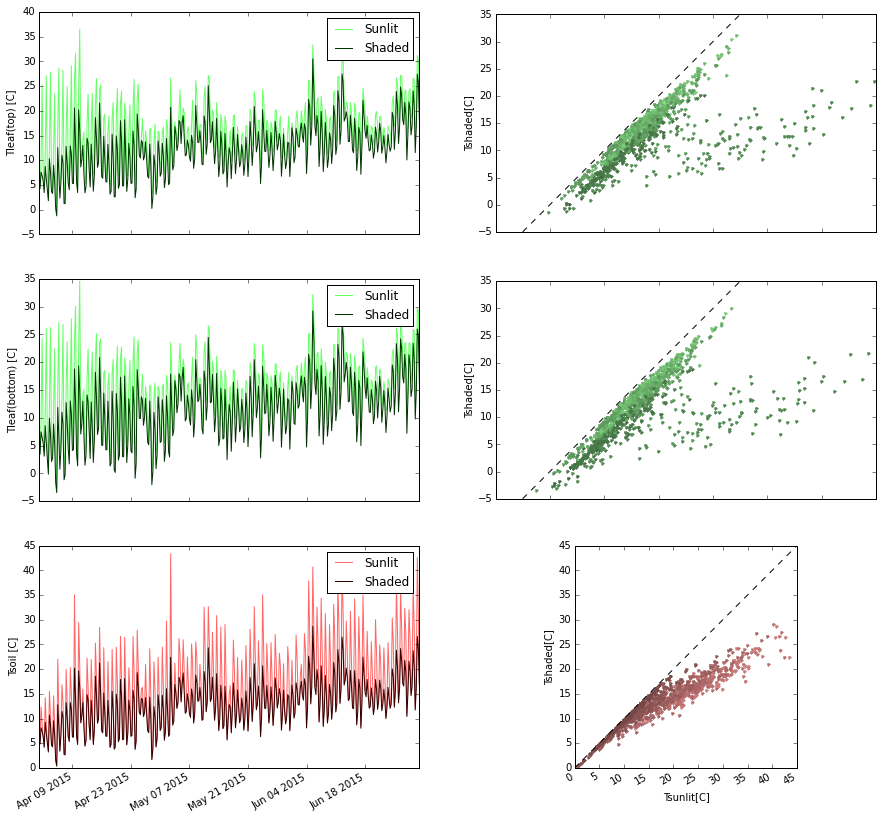

In [139]:
hour =  np.array([day.hour for day in state_grid_days])

# i10 = np.any([hour==0, hour== 2,hour== 4,hour== 6,hour==8,\
#               hour==10,hour==12,hour==14,hour==16,hour==18,\
#               hour==20,hour==22,hour==24],axis=0)

i10 = np.any([hour==0, hour== 6,hour==12,hour==18],axis=0)
# i10 = 10==hour
   
h1=plt.figure(figsize=[15,15])
plt.subplot(3,2,1)
# plt.plot(state_grid_days,Tcu[:,-1],color=[0.4,1,0.4])
# plt.plot(state_grid_days,Tch[:,-1],color=[0,0.2,0])
plt.plot(state_grid_days[i10],Tcu[i10,-1],color=[0.4,1,0.4])
plt.plot(state_grid_days[i10],Tch[i10,-1],color=[0,0.2,0])
plt.ylabel('Tleaf(top) [C]')
plt.legend(['Sunlit','Shaded'])

plt.subplot(3,2,2,aspect='equal')
for h in np.unique(hour):
    i = h==hour
    c = (1-np.abs(h-12)/24.)*0.8
    plt.plot(Tcu[i,-1],Tch[i,-1],'.',color=[c*0.6,c, c*0.6])
    
# plt.plot(Tcu[:,-1],Tch[:,-1],'go')
plt.plot([-5,35],[-5,35],'--k')
plt.xlabel('Tsunlit[C]')
plt.ylabel('Tshaded[C]')


plt.subplot(3,2,3)

# plt.plot(state_grid_days,Tcu[:,0],color=[0.4,1,0.4])
# plt.plot(state_grid_days,Tch[:,0],color=[0,0.2,0])
plt.plot(state_grid_days[i10],Tcu[i10,0],color=[0.4,1,0.4])
plt.plot(state_grid_days[i10],Tch[i10,0],color=[0,0.2,0])
plt.ylabel('Tleaf(bottom) [C]')
plt.legend(['Sunlit','Shaded'])

plt.subplot(3,2,4,aspect='equal')
for h in np.unique(hour):
    i = h==hour
    c = (1-np.abs(h-12)/24.)*0.8
    plt.plot(Tcu[i,0],Tch[i,0],'.',color=[c*0.6,c, c*0.6])
plt.plot([-5,35],[-5,35],'--k')
plt.xlabel('Tsunlit[C]')
plt.ylabel('Tshaded[C]')


plt.subplot(3,2,5)
# plt.plot(state_grid_days,Tsu,'-',color=[1,0.4,0.4])
# plt.plot(state_grid_days,Tsh,'-',color=[0.2,0,0])
plt.plot(state_grid_days[i10],Tsu[i10],'-',color=[1,0.4,0.4])
plt.plot(state_grid_days[i10],Tsh[i10],'-',color=[0.2,0,0])
plt.ylabel('Tsoil [C]')
plt.legend(['Sunlit','Shaded'])


plt.subplot(3,2,6,aspect='equal')
for h in np.unique(hour):
    i = h==hour
    c = (1-np.abs(h-12)/24.)*0.8
    plt.plot(Tsu[i],Tsh[i],'.',color=[c,c*0.6, c*0.6])
plt.plot([0,45],[0,45],'--k')
plt.xlabel('Tsunlit[C]')
plt.ylabel('Tshaded[C]')
plt.xlim([0, 45])
plt.ylim([0, 45])

h1.autofmt_xdate()
plt.savefig('EOLDAS Retrieved Canopy Component temperatures.png')

In [ ]:
# lai_retr_sigma = np.array(retrieved_value_opt['sigma']['lai'])

try:
    U                              = retrieved_value_thm['real_ci75pc']['lai'] 
    UU                             = retrieved_value_thm['real_ci95pc']['lai'] 
    L                              = retrieved_value_thm['real_ci25pc']['lai']    
    LL                             = retrieved_value_thm['real_ci5pc']['lai']
except:
    U                              = lai
    L                              = lai
    UU                             = lai
    LL                             = lai
    
UE                                 =  U-lai
LE                                 = lai -  L
lai_sigma                          = np.mean([UE,LE],0)
    

plt.figure(figsize=[15,7])
plt.subplot(4,1,1)
plt.plot(state_grid_days,lai)
plt.ylabel('lai')
plt.vlines(modisdates_Tb,0,0.2,color='r', linestyles='--')
plt.vlines(modisdates+datetime.timedelta(0.1),0,0.2,color='g', linestyles='--')

plt.subplot(4,1,2)
plt.plot(state_grid_days,Cdm)
plt.ylabel('Cdm')

plt.subplot(4,1,3)
plt.plot(state_grid_days,emissivity_leaf,'g')
plt.plot(state_grid_days,emissivity_soil,'r')
plt.ylabel('Emissivity')

plt.subplot(4,1,4)
plt.plot(state_grid_days,Vcmo)
plt.ylabel('Vcmo')
plt.vlines(modisdates_Tb,20,22,color='r', linestyles='--')
plt.vlines(modisdates,20,22,color='g', linestyles='--')
# plt.plot( modisdates_Tb, Tb.T - 273.15,'x');


# for i in enumerate(state_grid_days):
#     SCOPE_tools

# WHAT NEEDS to be done for completion

### Run SAIL

In [ ]:
import prosail

mindatum = datetime.datetime(2010,4,1)# datetime.datetime(2010,7,1)
maxdatum = datetime.datetime(2010,8,1)# datetime.datetime(2010,7,5)
    
# measured LAI
ierror = np.isnan(LAI_r_avs);
vegs = [] 
LAIs = []
for i,veg in enumerate(veg_dates_s):
    if ~ierror[i]:
        vegs.append(veg_dates_s[i])
        LAIs.append(LAI_r_avs[i])
LAIs = np.array(LAIs)

plt.figure(figsize=[15,5])        
plt.plot(doy_retr,LAI_priori,'m')
plt.fill_between(doy_retr,U,L,facecolor=[0.5, 0.5, 0.5])
plt.fill_between(doy_retr,UU,LL,facecolor=[0.8, 0.8, 0.8])
plt.plot(doy_retr,lai,'g-',linewidth=2);   
plt.vlines(doy_meas,0,4,linestyle='dashed',color='r')
plt.errorbar(vegs, LAIs, yerr=LAIs*0.05,fmt='b>-');
plt.hlines(state_opt.parameter_min['lai'],doy_retr[0],doy_retr[-1],color='k',linewidth=2,linestyle='dashed')
plt.xlim([mindatum,maxdatum]);


vars = ['cab','cw','cbrown']
print len(doy_meas)

for var in vars:
    try:
        plt.figure(figsize=[15,5])
        plt.plot(doy_retr,retrieved_value_opt['real_map'][var],'o')
        plt.fill_between(doy_retr,retrieved_value_opt['real_ci25pc'][var],retrieved_value_opt['real_ci75pc'][var],facecolor=[0.8, 0.8, 0.8])

        plt.xlim([mindatum,maxdatum]);
        plt.title(var)
        plt.hlines(state_opt.parameter_max[var],doy_retr[0],doy_retr[-1],color='k',linewidth=2,linestyle='dashed')
        plt.hlines(state_opt.parameter_min[var],doy_retr[0],doy_retr[-1],color='k',linewidth=2,linestyle='dashed')
        plt.ylim([state_opt.parameter_min[var]*0.99,state_opt.parameter_max[var]*1.01])
    except:
        plt.close()    
    

for i,v in enumerate(doy_meas):
    print doy_meas[i], np.round(sza_r[i].T/5.)*5.,np.round(vza_r[i].T/5.)*5., np.round(raa_r[i].T/15.)*15.

In [ ]:
lai_old  = copy.deepcopy(lai)

In [ ]:
# collocate LAI for cross-comparison plot
doy_meas_n  = np.array([doy.toordinal()*24*60 + doy.hour*60 +doy.minute for doy in doy_meas]).astype('float')
doy_meas_in = np.array([doy.toordinal()*24*60 + doy.hour*60 +doy.minute for doy in vegs]).astype('float')
doy_retr_n = np.array([doy.toordinal()*24*60 + doy.hour*60 +doy.minute for doy in doy_retr]).astype('float')

lai_meas_i = np.interp(doy_retr_n,doy_meas_in,LAIs)
lai_meas_i_sigma = lai_meas_i*0.05

# calculate distance of retrieved to actual observation for color coding
Doy_meas_n,Doy_retr_n = np.meshgrid(doy_meas_n,doy_retr_n)
D = np.abs(Doy_meas_n-Doy_retr_n)
Dmin = np.array(np.min(D,1))


i3h = Dmin<3*60
i1d = Dmin<24*60
i3d = (Dmin>3*60) * (Dmin<3*24*60)
imd = (Dmin>=3*24*60)

# fitting line to retrievals
# without taking into account uncertainties
x = np.linspace(np.min(lai_meas_i),np.max(lai_meas_i),5)
x3h1 = lai_meas_i[i3h]
x3h2 = lai[i3h]
P3h = np.polyfit(x3h1,x3h2,1)
P1d = np.polyfit(lai_meas_i[i1d],lai[i1d],1)
P3d = np.polyfit(lai_meas_i[i3d],lai[i3d],1)
Pmd = np.polyfit(lai_meas_i[imd],lai[imd],1)

P3hstr = 'F = %3.2f' % P3h[1] + '+ %3.2f X' % P3h[0]
P1dstr = 'F = %3.2f' % P1d[1] + '+ %3.2f X' % P1d[0]
P3dstr = 'F = %3.2f' % P3d[1] + '+ %3.2f X' % P3d[0]
Pmdstr = 'F = %3.2f' % Pmd[1] + '+ %3.2f X' % Pmd[0]
#with taking into account uncertainties
sigma_x = lai_meas_i_sigma
sigma_y = lai_sigma
sigma = (sigma_x/lai_meas_i + sigma_y/lai)*((lai+lai_meas_i)/2)


P3h2 = np.roll(np.polynomial.polynomial.polyfit(x3h1, x3h2, 1, rcond=None, full=False, w=1/sigma[i3h]),1)
P1d2 = np.roll(np.polynomial.polynomial.polyfit(lai_meas_i[i1d], lai[i1d], 1, rcond=None, full=False, w=1/sigma[i1d]),1)
P3d2 = np.roll(np.polynomial.polynomial.polyfit(lai_meas_i[i3d], lai[i3d], 1, rcond=None, full=False, w=1/sigma[i3d]),1)
Pmd2 = np.roll(np.polynomial.polynomial.polyfit(lai_meas_i[imd], lai[imd], 1, rcond=None, full=False, w=1/sigma[imd]),1)


P3hstr = 'F = %3.2f' % P3h2[1] + '+ %3.2f X' % P3h2[0]
P1dstr = 'F = %3.2f' % P1d2[1] + '+ %3.2f X' % P1d2[0]
P3dstr = 'F = %3.2f' % P3d2[1] + '+ %3.2f X' % P3d2[0]
Pmdstr = 'F = %3.2f' % Pmd2[1] + '+ %3.2f X' % Pmd2[0]


# plot output
plt.figure(figsize=[10,10])
plt.errorbar(lai_meas_i[i1d],lai[i1d],xerr=sigma_x[i1d],yerr=sigma_y[i1d],fmt='*',color = 'c',markersize=5,linewidth=1)
plt.errorbar(lai_meas_i[i3h],lai[i3h],xerr=sigma_x[i3h],yerr=sigma_y[i3h],fmt='o',color = 'g',markersize=10,linewidth=1)

plt.plot(x,np.polyval(P1d2,x),'-',color = 'c')
plt.plot(x,np.polyval(P3h2,x),'-',color = 'g')
plt.plot(x,x,'k:')
plt.xlim([0,4])
plt.ylim([0,4])
plt.xlabel('Measured LAI [m2/m2]')
plt.ylabel('Retrieved LAI [m2/m2]')
plt.legend(['D<1 days', 'D<3 hours',P1dstr,P3hstr,'1:1'],0)
plt.savefig('Retrieval using only SAIL ultimate final run.png')

print 'Results of Fit for >3 days: ' + Pmdstr
print 'Results of Fit for <3 days: ' + P3dstr
print 'Results of Fit for <1 days: ' + P1dstr
print 'Results of Fit for <3h days:' + P3hstr

#-0.93 +126 x

In [ ]:
V = [state_opt.default_values[paramname] for i,paramname in enumerate(opt_observations.selected_parameters)]
wv = np.arange(400, 2501,1)
bsoil = 1.
psoil = 0.3
surf_refl_lai0 = prosail.run_prosail(V[0], V[1], V[2], V[3], V[4], V[5], 0.0, V[7], 0, bsoil, bsoil, 0.01, 30, 0, 120, 2 )
surf_refl_lai7 = prosail.run_prosail(V[0], V[1], V[2], V[3], V[4], V[5], 7.0, V[7], 0, psoil, psoil, 0.01, 30, 0, 120, 2 )

# Check the simulated reflectances vs retrieved reflectances
rho_rs = np.array(opt_observations.fwd_modelled_obs).T
plt.figure(figsize=[15,10])
plt.subplot(1,2,1)
plt.plot(rapideye_c[iband],rho_r[iband,1],'og',linewidth=2)
plt.plot(rapideye_c[iband],rho_r[iband,2],'ob',linewidth=2)
plt.plot(rapideye_c[iband],rho_r[iband,3],'or',linewidth=2)
plt.plot(rapideye_c[iband],rho_r[iband,4],'oc',linewidth=2)
plt.plot(rapideye_c[iband],rho_r[iband,5],'om',linewidth=2)
plt.ylabel('Observations')
plt.plot(wv[0:450],surf_refl_lai0[0:450],'--k')
plt.plot(wv[0:450],surf_refl_lai7[0:450],'--k')

plt.subplot(1,2,2)
plt.plot(rapideye_c[iband],rho_rs[iband,0],'og',linewidth=2)
plt.plot(rapideye_c[iband],rho_rs[iband,1],'ob',linewidth=2)
plt.plot(rapideye_c[iband],rho_rs[iband,2],'or',linewidth=2)
plt.plot(rapideye_c[iband],rho_rs[iband,3],'oc',linewidth=2)
plt.plot(rapideye_c[iband],rho_rs[iband,4],'om',linewidth=2)
plt.ylabel('Simulation')
plt.legend(doy_meas[1:6],0)
plt.plot(wv[0:450],surf_refl_lai0[0:450],'--k')
plt.plot(wv[0:450],surf_refl_lai7[0:450],'--k')


# plt.figure(figsize=[5,5])
plt.figure(figsize=[15,10])
plt.plot(rho_r[0,1:6],rho_rs[0,0:5],'og')
plt.plot(rho_r[1,1:6],rho_rs[1,0:5],'ob')
plt.plot(rho_r[2,1:6],rho_rs[2,0:5],'or')
plt.plot(rho_r[3,1:6],rho_rs[3,0:5],'oc')
plt.plot(rho_r[4,1:6],rho_rs[4,0:5],'om')

plt.plot([0,0.5],[0,0.5],'--k')
plt.xlabel('measured reflectances [-]')
plt.ylabel('simulated reflectances [-]')
plt.legend(['Band 1', 'Band 2', 'Band 3', 'Band 4', 'Band 5'])


# em=opt_observations.emulators[30,0,120]
# em.thresh

In [ ]:
# x_dict2 = state_opt._unpack_to_dict(xx)

# state_config2 = OrderedDict()

# for param in opt_observations.selected_parameters:
#     state_config2[param] = state_config[param]
# #     if param in [par for par in x_dict.iterkeys()]:
# #         x_dict2[param] = x_dict[param]
        
# # cost, der_cost = state_opt.cost(xx)

# # state_config
# Jobs,der_cost1 = opt_observations.der_cost(x_dict2,state_config2)
# Jprior,der_cost2 = prior.der_cost(x_dict2,state_config2)
# Jreg,der_cost3 = temporal.der_cost(x_dict2,state_config2)
# Jtot = Jobs + Jprior + Jreg
# print  Opt_unc_string_run
# print '- Jtot = %4.3e' % Jtot +  '\t Jobs = %4.3e' % Jobs + '\t Jprior = %4.3e' % Jprior +  '\t Jreg = %4.3e' % Jreg
# print '- Jobs = %3.2f%%' % (Jobs/Jtot*100)  + '\t Jprior = %3.2f%%' % (Jprior/Jtot*100) +  '\t Jreg = %3.2f%%' % (Jreg/Jtot*100) 

# # plt.plot(x_dict2['lai'])
# plt.subplot(2,1,1)
# plt.plot(der_cost1)
# plt.subplot(2,1,2)
# plt.plot(der_cost3)

Optrel_unc=26.0 %
- Jtot = 4.368e+04	 Jobs = 1.181e+02	 Jprior = 4.356e+04	 Jreg = 0.000e+00
- Jobs = 0.27%	 Jprior = 99.73%	 Jreg = 0.00%

Optrel_unc= 2.6 %
- Jtot = 4.740e+04	 Jobs = 3.846e+03	 Jprior = 4.356e+04	 Jreg = 0.000e+00
- Jobs = 8.11%	 Jprior = 91.89%	 Jreg = 0.00%

if the temporal resolution decreases Jprior and Jreg decreases as well (with roughly the same factor that dt increases). This however does not mean that that gamma's do not need to be changed. While Jreg and Jproir may increase roughly similar, Jobs will decrease. This means that Jtot will decrease and the relative importance of Jreg and Jprior will increase, while the rel. importance Jobs will decrease. Speculation: In order to keep the same output, one should therefore basically decrease gamma to keep Jobs and Jreg in comparable to each other. 

### 5.2.2 with only microwave operators

In [ ]:
retrieved_value_mw = copy.deepcopy(retrieved_value_opt)

In [ ]:
# state_mw = copy.deepcopy(state)
# state_mw.add_operator ( "Prior", prior)
# state_mw.add_operator ("CMEM observations (50)", observations50)
# state_mw.add_operator ("CMEM observations (55)", observations55)
# state_mw.add_operator ("CMEM observations (60)", observations60)
# state_mw.add_operator ("CMEM observations (65)", observations65)
# state_mw.add_operator ("regularisation", temporal)

In [ ]:
# t1 = datetime.datetime.now()

# retrieved_value_mw,xx                =  state_mw.optimize ( x0=x_dict, do_unc=False)

# t2 = datetime.datetime.now()
# deltat = ((t2-t1).total_seconds())/60
# print 'Simulation time = %4.3f [min]' % deltat

In [ ]:
# x_dict2 = state_opt._unpack_to_dict(xx)

# state_config2 = OrderedDict()

# for param in observations55.selected_parameters:
#     state_config2[param] = state_config[param]
# #     if param in [par for par in x_dict.iterkeys()]:
# #         x_dict2[param] = x_dict[param]
        
# # cost, der_cost = state_opt.cost(xx)

# # state_config
# Jobs1,der_cost = observations55.der_cost(x_dict2,state_config2)
# Jobs2,der_cost = observations55.der_cost(x_dict2,state_config2)
# Jprior,der_cost = prior.der_cost(x_dict,state_config)
# Jreg,der_cost = temporal.der_cost(x_dict,state_config)
# Jobs = Jobs1 + Jobs2
# Jtot = Jobs + Jprior + Jreg
# print  Opt_unc_string_run
# print '- Jtot = %4.3e' % Jtot +  '\t Jobs = %4.3e' % Jobs + '\t Jprior = %4.3e' % Jprior +  '\t Jreg = %4.3e' % Jreg
# print '- Jobs = %3.2f%%' % (Jobs/Jtot*100)  + '\t Jprior = %3.2f%%' % (Jprior/Jtot*100) +  '\t Jreg = %3.2f%%' % (Jreg/Jtot*100)

Optrel_unc= 2.6 %
- Jtot = 5.268e+04	 Jobs = 9.123e+03	 Jprior = 4.356e+04	 Jreg = 0.000e+00
- Jobs = 17.32%	 Jprior = 82.68%	 Jreg = 0.00%

Optrel_unc=26.0 %
- Jtot = 5.268e+04	 Jobs = 9.123e+03	 Jprior = 4.356e+04	 Jreg = 0.000e+00
- Jobs = 17.32%	 Jprior = 82.68%	 Jreg = 0.00%



### 5.2.3 with both optical and  microwave operators

In [ ]:
retrieved_value_full = copy.deepcopy(retrieved_value_opt)

In [ ]:
# state_full = copy.deepcopy(state)
# state_full.add_operator ( "Prior", prior)
# state_full.add_operator ("RapidEye observations", opt_observations)
# state_full.add_operator ("CMEM observations (55)", observations55)
# state_full.add_operator ("CMEM observations (60)", observations60)
# state_full.add_operator ("regularisation", temporal )

In [ ]:
# t1 = datetime.datetime.now()
# print t1

# retrieved_value_full,xx               =  state_full.optimize ( x0=x_dict, do_unc=True)

# t2 = datetime.datetime.now()
# deltat = ((t2-t1).total_seconds())/60
# print 'Simulation time = %4.3f [min]' % deltat

In [ ]:
# x_dict2 = state_full._unpack_to_dict(xx)

# state_config2 = OrderedDict()

# for param in observations55.selected_parameters:
#     state_config2[param] = state_config[param]
# #     if param in [par for par in x_dict.iterkeys()]:
# #         x_dict2[param] = x_dict[param]
        
# # cost, der_cost = state_opt.cost(xx)

# # state_config
# Jobs,der_cost = opt_observations.der_cost(x_dict2,state_config2)
# Jobs1,der_cost = observations55.der_cost(x_dict2,state_config2)
# Jobs2,der_cost = observations55.der_cost(x_dict2,state_config2)
# Jprior,der_cost = prior.der_cost(x_dict,state_config)
# Jreg,der_cost = temporal.der_cost(x_dict,state_config)
# Jobs_opt = Jobs
# Jobs_mw = Jobs1 + Jobs2 
# Jtot = Jobs_opt + Jobs_mw + Jprior + Jreg
# print  Opt_unc_string_run
# print '- Jtot = %4.3e' % Jtot +  '\t Jobs_opt = %4.3e' % Jobs_opt +  '\t Jobs_mw = %4.3e' % Jobs_mw + '\t Jprior = %4.3e' % Jprior +  '\t Jreg = %4.3e' % Jreg
# print '- Jobs_opt = %3.2f%%' % (Jobs_opt/Jtot*100) + '- Jobs_mw = %3.2f%%' % (Jobs_mw/Jtot*100)  + '\t Jprior = %3.2f%%' % (Jprior/Jtot*100) +  '\t Jreg = %3.2f%%' % (Jreg/Jtot*100)

Optrel_unc=26.0 %
- Jtot = 5.319e+04	 Jobs_opt = 1.824e+02	 Jobs_mw = 9.450e+03	 Jprior = 4.356e+04	 Jreg = 0.000e+00
- Jobs_opt = 0.34%- Jobs_mw = 17.77%	 Jprior = 81.89%	 Jreg = 0.00%

Optrel_unc= 2.6 %
- Jtot = 7.501e+04	 Jobs_opt = 2.185e+04	 Jobs_mw = 9.600e+03	 Jprior = 4.356e+04	 Jreg = 0.000e+00
- Jobs_opt = 29.13%- Jobs_mw = 12.80%	 Jprior = 58.07%	 Jreg = 0.00%

# 6. Post Processing

In [ ]:
date_g = state_grid.astype('float')/60/24
date_  = [(datetime.datetime.fromordinal(int(d)) + datetime.timedelta(days=d%1)) for d in date_g] 

data_no                        = retrieved_value_no['real_map']
# data_no_05p                    = retrieved_value_no['real_ci5pc']
# data_no_25p                    = retrieved_value_no['real_ci25pc']
# data_no_75p                    = retrieved_value_no['real_ci75pc']
# data_no_95p                    = retrieved_value_no['real_ci95pc']

data_opt                       = retrieved_value_opt['real_map']
# data_opt_05p                   = retrieved_value_opt['real_ci5pc']
# data_opt_25p                   = retrieved_value_opt['real_ci25pc']
# data_opt_75p                   = retrieved_value_opt['real_ci75pc']
# data_opt_95p                   = retrieved_value_opt['real_ci95pc']

data_mw                        = retrieved_value_mw['real_map']
# data_mw_05p                    = retrieved_value_mw['real_ci5pc']
# data_mw_25p                    = retrieved_value_mw['real_ci25pc']
# data_mw_75p                    = retrieved_value_mw['real_ci75pc']
# data_mw_95p                    = retrieved_value_mw['real_ci95pc']

data_full                      = retrieved_value_full['real_map']
# data_full_05p                  = retrieved_value_full['real_ci5pc']
# data_full_25p                  = retrieved_value_full['real_ci25pc']
# data_full_75p                  = retrieved_value_full['real_ci75pc']
# data_full_95p                  = retrieved_value_full['real_ci95pc']

#  plt.fill_between(dates, var_75unc, var_25unc, alpha=0.2)
#     plt.fill_between(dates, var_05unc, var_95unc, alpha=0.4)

In [ ]:
i       = 0
minTobs = np.min([np.min(Obs50_), np.min(Obs55_), np.min(Obs60_), np.min(Obs65_), np.min(Obs70_)])
maxTobs = np.max([np.max(Obs50_), np.max(Obs55_), np.max(Obs60_), np.max(Obs65_), np.max(Obs70_)])

params  = [k for k in state_config.iterkeys()]
typo    = [k for k in state_config.itervalues()]
strings = np.array(params)

str2    = '_short_mixedmodel'
N       = np.sum(np.array(typo)==3)

In [ ]:
Meas = dict()
Meas['Val'] = dict()
Meas['Val']['SM']  = SM1_av
Meas['Val']['Ts']  = Ts1_av
Meas['Val']['LAI'] = LAI_r_avs
Meas['Val']['Cdm'] = Cdm_r_avs/10
Meas['Val']['Cw']  = Cw_r_avs/10

Meas['Unc'] = dict()
Meas['Unc']['SM']  = SM1_unc
Meas['Unc']['Ts']  = Ts1_unc
Meas['Unc']['LAI'] = LAIunc_r_avs
Meas['Unc']['Cdm'] = Cdmunc_r_avs
Meas['Unc']['Cw']  = Cwunc_r_avs

Meas['T'] = dict()
Meas['T']['SM']  = np.array(dates_n)
Meas['T']['Ts']  = np.array(dates_n)
Meas['T']['LAI'] = np.array(veg_dates_sn)
Meas['T']['Cdm'] = np.array(veg_dates_sn)
Meas['T']['Cw']  = np.array(veg_dates_sn)

Meas['Units'] = dict()
Meas['Units']['SM']  = '[%]'
Meas['Units']['Ts']  = '[K]'
Meas['Units']['LAI'] = '[m2/m2]'
Meas['Units']['Cdm'] = '[g/cm2]'
Meas['Units']['Cw']  = '[cm3/cm2]'

# Meas['T']

In [ ]:
Meas2 = dict()
Meas2['Val'] = dict()
Meas2['Val']['fwc_lsm_i1']  = SM1_av
Meas2['Val']['ftl_lsm_i1']  = Ts1_av
Meas2['Val']['lai'] = LAI_r_avs
Meas2['Val']['cm'] = Cdm_r_avs/10
Meas2['Val']['cw']  = Cw_r_avs/10

Meas2['Unc'] = dict()
Meas2['Unc']['fwc_lsm_i1']  = SM1_unc
Meas2['Unc']['ftl_lsm_i1']  = Ts1_unc
Meas2['Unc']['lai'] = LAIunc_r_avs
Meas2['Unc']['cm'] = Cdmunc_r_avs
Meas2['Unc']['cw']  = Cwunc_r_avs

Meas2['T'] = dict()
Meas2['T']['fwc_lsm_i1']  = np.array(dates_n)
Meas2['T']['ftl_lsm_i1']  = np.array(dates_n)
Meas2['T']['lai'] = np.array(veg_dates_sn)
Meas2['T']['cm'] = np.array(veg_dates_sn)
Meas2['T']['cw']  = np.array(veg_dates_sn)

# 7. Save data

## 7.0 Measurements

In [ ]:
outputdir = './data-output/Land Surface Parameter Retrieval/'
string = 'LMEB-SAIL Land Surface Parameter Retrieval, Measurements, ' + Opt_unc_string_run
for param in param_variable:
    np.savetxt(outputdir + string + ' Time of ' + param, Meas2['T'][param], '%5.4f')
    np.savetxt(outputdir + string + ' Values of ' + param, Meas2['Val'][param], '%5.4e')
    np.savetxt(outputdir + string + ' Uncertainties of ' + param, Meas2['Unc'][param], '%5.4e')
    
for param in param_constant:
    np.savetxt(outputdir + string + ' Time of ' + param, Meas2['T'][param], '%5.4f')
    np.savetxt(outputdir + string + ' Values of ' + param, Meas2['Val'][param], '%5.4e')
    np.savetxt(outputdir + string + ' Uncertainties of ' + param, Meas2['Unc'][param], '%5.4e')

## 7.1 only Optical

In [ ]:
outputdir = './data-output/Land Surface Parameter Retrieval/'
string = 'LMEB-SAIL Land Surface Parameter Retrieval, SAIL only, ' + Opt_unc_string_run
for param in param_variable:
    np.savetxt(outputdir + string + ' Time of ' + param, state_grid, '%5.4f')
    np.savetxt(outputdir + string + ' Values of ' + param, data_opt[param], '%5.4e')    
#     np.savetxt(outputdir + string + '  5% quantile of ' + param, data_opt_05p[param],  '%5.4e')
#     np.savetxt(outputdir + string + ' 25% quantile of ' + param, data_opt_25p[param], '%5.4e')
#     np.savetxt(outputdir + string + ' 75% quantile of ' + param, data_opt_75p[param], '%5.4e')
#     np.savetxt(outputdir + string + ' 95% quantile of ' + param, data_opt_95p[param], '%5.4e')


dummy = np.zeros_like(data_opt[param_variable[0]])
for param in param_constant:
    np.savetxt(outputdir + string + ' Time of ' + param, state_grid, '%5.4f')
    np.savetxt(outputdir + string + ' Values of ' + param, data_opt[param]+dummy, '%5.4e') 

# fwd_opt    = state_opt.operators['RapidEye observations'].fwd_modelled_obs
# obss_opt   = state_opt.operators['RapidEye observations'].observations

# Jprior     = state_opt.cost_components['Prior']
# Jobs_opt   = state_opt.cost_components['RapidEye observations']
# Jreg       = state_opt.cost_components['regularisation']
# Jtot       = np.sum(Jprior) + np.sum(Jobs_opt)+ np.sum(Jreg) 

# np.savetxt(outputdir + string + ' Fwd Simulations Opt', fwd_opt, '%5.4e')
# np.savetxt(outputdir + string + ' Observations Opt', obss_opt, '%5.4e')

# np.savetxt(outputdir + string + ' Cost of Prior', Jprior, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of Obs Opt', Jobs_opt, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of Treg', Jreg, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of total', [Jtot], '%5.4e')

## 7.2 Only Microwave

In [ ]:
outputdir = './data-output/Land Surface Parameter Retrieval/'
string = 'LMEB-SAIL Land Surface Parameter Retrieval, LMEB only, ' + Opt_unc_string_run
for param in param_variable:
    np.savetxt(outputdir + string + ' Time of ' + param, state_grid, '%5.4f')
    np.savetxt(outputdir + string + ' Values of ' + param, data_mw[param], '%5.4e')
#     np.savetxt(outputdir + string + '  5% quantile of ' + param, data_mw_05p[param],  '%5.4e')
#     np.savetxt(outputdir + string + ' 25% quantile of ' + param, data_mw_25p[param], '%5.4e')
#     np.savetxt(outputdir + string + ' 75% quantile of ' + param, data_mw_75p[param], '%5.4e')
#     np.savetxt(outputdir + string + ' 95% quantile of ' + param, data_mw_95p[param], '%5.4e')

# dummy = np.zeros_like(data_mw[param_variable[0]])
# for param in param_constant:
#     np.savetxt(outputdir + string + ' Time of ' + param, state_grid, '%5.4f')
#     np.savetxt(outputdir + string + ' Values of ' + param, data_mw[param]+dummy, '%5.4e') 
    
# fwd_mw55   = state_mw.operators['CMEM observations (55)'].fwd_modelled_obs
# fwd_mw60   = state_mw.operators['CMEM observations (60)'].fwd_modelled_obs

# obss_mw55  = state_mw.operators['CMEM observations (55)'].observations
# obss_mw60  = state_mw.operators['CMEM observations (60)'].observations

# Jprior     = state_mw.cost_components['Prior']
# Jobs_mw55  = state_mw.cost_components['CMEM observations (55)']
# Jobs_mw60  = state_mw.cost_components['CMEM observations (60)']
# # Jreg       = state_mw.cost_components['regularisation']
# Jtot       = np.sum(Jprior) + np.sum(Jobs_mw55)+ np.sum(Jobs_mw60) + np.sum(Jreg) 

# np.savetxt(outputdir + string + ' Fwd Simulations Mw55', fwd_mw55, '%5.4e')
# np.savetxt(outputdir + string + ' Fwd Simulations Mw60', fwd_mw60, '%5.4e')

# np.savetxt(outputdir + string + ' Observations Mw55', obss_mw55, '%5.4e')
# np.savetxt(outputdir + string + ' Observations Mw60', obss_mw60, '%5.4e')

# np.savetxt(outputdir + string + ' Cost of Prior', Jprior, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of Obs Mw55', Jobs_mw55, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of Obs Mw60', Jobs_mw60, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of Treg', Jreg, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of total', [Jtot], '%5.4e')

## 7.3 Optical and Microwave

In [ ]:
# outputdir = './data-output/Land Surface Parameter Retrieval/'
# string = 'LMEB-SAIL Land Surface Parameter Retrieval, LMEB and SAIL, ' + Opt_unc_string_run
# for param in param_variable:
#     np.savetxt(outputdir + string + ' Time of ' + param, state_grid, '%5.4f')
#     np.savetxt(outputdir + string + ' Values of ' + param, data_full[param], '%5.4e')
#     np.savetxt(outputdir + string + '  5% quantile of ' + param, data_full_05p[param],  '%5.4e')
#     np.savetxt(outputdir + string + ' 25% quantile of ' + param, data_full_25p[param], '%5.4e')
#     np.savetxt(outputdir + string + ' 75% quantile of ' + param, data_full_75p[param], '%5.4e')
#     np.savetxt(outputdir + string + ' 95% quantile of ' + param, data_full_95p[param], '%5.4e')

# dummy = np.zeros_like(data_full[param_variable[0]])
# for param in param_constant:
#     np.savetxt(outputdir + string + ' Time of ' + param, state_grid, '%5.4f')
#     np.savetxt(outputdir + string + ' Values of ' + param, data_full[param]+dummy, '%5.4e') 
    
# fwd_opt    = state_full.operators['RapidEye observations'].fwd_modelled_obs
# fwd_mw55   = state_full.operators['CMEM observations (55)'].fwd_modelled_obs
# fwd_mw60   = state_full.operators['CMEM observations (60)'].fwd_modelled_obs

# obss_opt   = state_full.operators['RapidEye observations'].observations
# obss_mw55  = state_full.operators['CMEM observations (55)'].observations
# obss_mw60  = state_full.operators['CMEM observations (60)'].observations

# Jprior     = state_full.cost_components['Prior']
# Jobs_opt   = state_full.cost_components['RapidEye observations']
# Jobs_mw55  = state_full.cost_components['CMEM observations (55)']
# Jobs_mw60  = state_full.cost_components['CMEM observations (60)']
# Jreg       = state_full.cost_components['regularisation']
# Jtot       = np.sum(Jprior) + np.sum(Jobs_opt) + np.sum(Jobs_mw55)+ np.sum(Jobs_mw60) + np.sum(Jreg) 

# np.savetxt(outputdir + string + ' Fwd Simulations Opt', fwd_opt, '%5.4e')
# np.savetxt(outputdir + string + ' Fwd Simulations Mw55', fwd_mw55, '%5.4e')
# np.savetxt(outputdir + string + ' Fwd Simulations Mw60', fwd_mw60, '%5.4e')

# np.savetxt(outputdir + string + ' Observations Opt', obss_opt, '%5.4e')
# np.savetxt(outputdir + string + ' Observations Mw55', obss_mw55, '%5.4e')
# np.savetxt(outputdir + string + ' Observations Mw60', obss_mw60, '%5.4e')

# np.savetxt(outputdir + string + ' Cost of Prior', Jprior, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of Obs Opt', Jobs_opt, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of Obs Mw55', Jobs_mw55, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of Obs Mw60', Jobs_mw60, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of Treg', Jreg, '%5.4e')
# np.savetxt(outputdir + string + ' Cost of total', [Jtot], '%5.4e')

# 8. Plotting retrieved Variables

## 8.0 No operators

In [ ]:
plt.figure(figsize=(15,4))
plt.xlim(mindate,maxdate)
plt.xlabel('Time [-]')
plt.ylabel('Rapid Eye Obs')


params  = [k for k in state_config.iterkeys()]

j=1
plt.figure(figsize=(15,10))
for i,param in enumerate(params):
    bounds=state.bounds[j]
    if state_no.transformation_dict.has_key ( param ):
        mu = state_no.invtransformation_dict[param] ( mu_prior[param] )        
    else: 
        mu =  mu_prior[param]
        
    if typo[i]==3:
        plt.subplot(N,1,j)
        minV = np.min(data_no[param])*0.99
        maxV = np.max(data_no[param])*1.01
#         minV = np.min([np.min(data_no[param]), np.min(data_no_05p[param]), np.min(data_no_95p[param]), mu]) *0.999
#         maxV = np.max([np.max(data_no[param]), np.max(data_no_05p[param]), np.max(data_no_95p[param]), mu]) *1.001
#         plt.fill_between(date_, data_no_25p[param], data_no_75p[param], alpha=0.2)
#         plt.fill_between(date_, data_no_05p[param], data_no_95p[param], alpha=0.4)
        plt.plot(date_,data_no[param])
        plt.plot(date_,mu+np.zeros_like(date_g),':g') 
        plt.ylabel(param)
        plt.title('Retrieved by EOLDAS using no observations')        
        plt.legend(['Retrieved','Apriori','used','unused'],0)
        plt.ylim([minV, maxV])
        j = j+1
plot_string = 'Retrieval using no operators, std(LAI = %3.2f' % std_prior['lai'] + ',Ts = %3.2f' % std_prior['ftl_lsm_i1']  + ',SM = %3.2f)' % std_prior['fwc_lsm_i1']
plt.savefig(plot_string + '.png')

## 8.1 Using Only Optical

In [ ]:
plt.figure(figsize=(15,4))
plt.vlines(rapideye_dates[passer],minTobs,maxTobs,linestyles= 'dashed')
plt.xlim(mindate,maxdate)
plt.xlabel('Time [-]')
plt.ylabel('Rapid Eye Obs')

params  = [k for k in state_config.iterkeys()]

j=1
plt.figure(figsize=(15,10))
for i,param in enumerate(params):
    bounds=state.bounds[j]
    if state_opt.transformation_dict.has_key ( param ):
        mu = state_opt.invtransformation_dict[param] ( mu_prior[param] )        
    else: 
        mu =  mu_prior[param]
        
    if typo[i]==3:
        plt.subplot(N,1,j)
        
        minV = np.min(data_opt[param])*0.999
        maxV = np.max(data_opt[param])*1.001
#         minV = np.min([np.min(data_opt[param]), np.min(data_opt_05p[param]), np.min(data_opt_95p[param]), mu]) *0.999
#         maxV = np.max([np.max(data_opt[param]), np.max(data_opt_05p[param]), np.max(data_opt_95p[param]), mu]) *1.001
#         plt.fill_between(date_, data_opt_25p[param], data_opt_75p[param], alpha=0.2)
#         plt.fill_between(date_, data_opt_05p[param], data_opt_95p[param], alpha=0.4)
        plt.plot(date_,data_opt[param])
        plt.plot(date_,mu+np.zeros_like(date_g),':g') 
        plt.vlines(rapideye_dates[passer],minV,maxV,linestyles= 'dashed')
        plt.ylabel(param)
#         plt.title('Retrieved by EOLDAS using optical')        
        plt.legend(['Retrieved','Apriori','Obs','unused'],0)
        plt.ylim([minV,maxV])
        plt.xlim([np.min(date_),np.max(date_)])
        j = j+1
        
string = 'Retrieval using only SAIL,  std(LAI = %3.2f' % std_prior['lai'] + ',Ts = %3.2f' % std_prior['ftl_lsm_i1']  + \
      ',SM = %3.2f)' % std_prior['fwc_lsm_i1'] + Opt_unc_string_run
plt.savefig(string + '.png')

why do we find fluctuations in SM and Tsoil, while no observations are made to cause them to change? 

## 8.2 Using Only Microwave

In [ ]:
# mindate                       = datetime.datetime(2010,   7,  1)
# maxdate                       = datetime.datetime(2010,   7,  14)

In [ ]:
print quality_.shape
print Obs55_.shape

minV  = np.min([np.min(Obs55_), np.min(Obs60_)])
maxV  = np.max([np.min(Obs55_), np.max(Obs60_)])
plt.figure(figsize=(15,4))
plt.plot(dates_, Obs55_[0,:].T*quality_,'x');
plt.plot(dates_, Obs55_[1,:].T*quality_,'o');
plt.plot(dates_, Obs60_[0,:].T*quality_,'+');
plt.plot(dates_, Obs60_[1,:].T*quality_,'>r');

plt.plot(dates_, Obs55_[0,:].T*(1-quality_),'x',color=[0.8,0.8,0.8]);
plt.plot(dates_, Obs55_[1,:].T*(1-quality_),'o',color=[0.8,0.8,0.8]);
plt.plot(dates_, Obs60_[0,:].T*(1-quality_),'+',color=[0.8,0.8,0.8]);
plt.plot(dates_, Obs60_[1,:].T*(1-quality_),'>',color=[0.8,0.8,0.8]);
plt.ylim(minV,maxV)

plt.xlim(mindate,maxdate)
plt.xlabel('Time [-]')
plt.ylabel('Tobs [K]')
plt.legend(['h(55)','v(55)','h(60)','v(60)']);

j=1
mu_ = np.zeros_like(params)
string = []
plt.figure(figsize=(15,10))
for i,param in enumerate(params):
    if state_mw.transformation_dict.has_key ( param ):
        mu = state_mw.invtransformation_dict[param] ( mu_prior[param] )
    else: 
        mu =  mu_prior[param]
    mu_[i] = mu[0]
        
    if typo[i]==3:
        plt.subplot(N,1,j)
        
        minV = np.nanmin(data_mw[param]) *0.999
        maxV = np.nanmax(data_mw[param]) *1.001
#         minV = np.nanmin([np.min(data_mw[param]), np.nanmin(data_mw_05p[param]), np.nanmin(data_mw_95p[param]), mu]) *0.999
#         maxV = np.nanmax([np.max(data_mw[param]), np.nanmax(data_mw_05p[param]), np.nanmax(data_mw_95p[param]), mu]) *1.001
        plt.plot(date_,data_mw[param])
#         plt.fill_between(date_, data_mw_25p[param], data_mw_75p[param], alpha=0.2)
#         plt.fill_between(date_, data_mw_05p[param], data_mw_95p[param], alpha=0.4)
        plt.plot(date_,mu+np.zeros_like(date_g),':g') 
        plt.ylabel(param)
#         plt.title('Retrieved by EOLDAS using microwave')        
        plt.legend(['Retrieved','Apriori','used','unused'])
        
        j = j+1
        
        plt.ylim([minV,maxV])
        plt.xlim(mindate,maxdate)
# plt.savefig('Retrieved with transformation' + str2 + '.png')

string2 = 'Retrieval using only LMEB,  std(LAI = %3.2f' % std_prior['lai'] + ',Ts = %3.2f' % std_prior['ftl_lsm_i1']  + \
      ',SM = %3.2f)' % std_prior['fwc_lsm_i1'] + Opt_unc_string_run
plt.savefig(string2 + '.png')
string2

## 8.3 Using Optical and microwave

In [ ]:
# plt.figure(figsize=(15,4))
# plt.plot(dates_, Obs50_.T,'o');
# plt.plot(dates_, Obs55_.T,'x');
# plt.plot(dates_, Obs60_.T,'+');
# plt.plot(dates_, Obs65_.T,'*');
# plt.plot(dates_, Obs70_.T,'>');
# plt.vlines(rapideye_dates[passer],minTobs,maxTobs,linestyles= 'dashed')

# plt.xlim(mindate,maxdate)
# plt.xlabel('Time [-]')
# plt.ylabel('Tobs [K]')
# plt.legend(['h(50)','v(50)','h(55)','v(55)','h(60)','v(60)','h(65)','v(65)','h(70)','v(70)']);


# j=1
# plt.figure(figsize=(15,10))
# # mu_ = np.zeros_like(param)
# for i,param in enumerate(params):
#     if state_full.transformation_dict.has_key ( param ):
#         mu = state_full.invtransformation_dict[param] ( mu_prior[param] )
#     else: 
#         mu =  mu_prior[param]
# #         mu_[i]
#     if typo[i]==3:
#         plt.subplot(N,1,j)
        
#         minV = np.nanmin(data_full[param]) *0.999
#         maxV = np.nanmax(data_full[param]) *1.001
# #         minV = np.nanmin([np.nanmin(data_full[param]), np.nanmin(data_full_05p[param]), np.nanmin(data_full_95p[param]), mu]) *0.999
# #         maxV = np.nanmax([np.nanmax(data_full[param]), np.nanmax(data_full_05p[param]), np.nanmax(data_full_95p[param]), mu]) *1.001
#         plt.plot(date_,data_full[param])
# #         plt.fill_between(date_, data_full_25p[param], data_full_75p[param], alpha=0.2)
# #         plt.fill_between(date_, data_full_05p[param], data_full_95p[param], alpha=0.4)
#         plt.plot(date_,mu+np.zeros_like(date_g),':g') 
#         plt.vlines(rapideye_dates[passer],minV,maxV,linestyles= 'dashed')
#         plt.ylabel(param)
# #         plt.title('Retrieved by EOLDAS using optical and microwave')        
#         plt.legend(['Retrieved','Apriori','Obs','unused'])
#         plt.ylim([minV,maxV])
#         plt.xlim([np.min(date_),np.max(date_)])
#         j = j+1
# string2 = 'Retrieval using LMEB and SAIL,  std(LAI = %3.2f' % std_prior['lai'] + ',Ts = %3.2f' % std_prior['ftl_lsm_i1']  + \
#       ',SM = %3.2f)' % std_prior['fwc_lsm_i1'] + Opt_unc_string_run
# plt.savefig(string2 +'.png')

### 8.1.4  difference with previous ones

In [ ]:
diff_full_mw = copy.deepcopy(data_mw)
diff_full_opt = copy.deepcopy(data_opt)
diff_mw_opt = copy.deepcopy(data_opt)

j=0
plt.figure(figsize=(15,10))
for i,param in enumerate(params):
    if typo[i]==3:
        diff_full_mw[param] = np.abs(data_full[param] - data_mw[param])+1e-9
        diff_full_opt[param] = np.abs(data_full[param] - data_opt[param])+1e-9
        diff_mw_opt[param]  = np.abs(data_mw[param] - data_opt[param])+1e-9
    
        
        plt.subplot(N,1,j)        
        plt.semilogy(date_,diff_full_mw[param],'r')
        plt.semilogy(date_,diff_full_opt[param],'b:')
        plt.semilogy(date_,diff_mw_opt[param],'g--')
        plt.ylabel('Delta ' + param)
        j = j+1
plt.legend(['Full - MW','Full - Opt', 'MW - Opt'])        
titel_string = 'Difference between full retrieval (using optical and microwave) and single retrieval'
plt.title(titel_string)
plt.savefig(titel_string + ', ' + Opt_unc_string_run + '.png')

# 9. Comparison with validation data

## 9.1 Collocate observations with validation measurements 

In [ ]:
Obs_opt = OrderedDict()
Obs_opt['SM']    = data_opt['fwc_lsm_i1']
Obs_opt['Ts']    = data_opt['ftl_lsm_i1']
Obs_opt['LAI']   = data_opt['lai']
Obs_opt['Cdm']   = data_opt['cm'] + Obs_opt['LAI']*0
Obs_opt['Cw']    = data_opt['cw']  + Obs_opt['LAI']*0


Obsunc_opt = OrderedDict()
Obsunc_opt['SM']    = data_opt_95p['fwc_lsm_i1'] - data_opt_05p['fwc_lsm_i1']
Obsunc_opt['Ts']    = data_opt_95p['ftl_lsm_i1'] - data_opt_05p['ftl_lsm_i1']
Obsunc_opt['LAI']   = data_opt_95p['lai']        - data_opt_05p['lai']
Obsunc_opt['Cdm']   = data_opt_95p['cm']         - data_opt_05p['cm'] + Obs_opt['LAI']*0
Obsunc_opt['Cw']    = data_opt_95p['cw']         - data_opt_05p['cw']  + Obs_opt['LAI']*0


Obs_mw = OrderedDict()
Obs_mw['SM']     = data_mw['fwc_lsm_i1']
Obs_mw['Ts']     = data_mw['ftl_lsm_i1']
Obs_mw['LAI']    = data_mw['lai']
Obs_mw['Cdm']    = data_mw['cm'] + Obs_mw['LAI']*0
Obs_mw['Cw']     = data_mw['cw']  + Obs_mw['LAI']*0

Obsunc_mw = OrderedDict()
Obsunc_mw['SM']    = data_mw_95p['fwc_lsm_i1'] - data_mw_05p['fwc_lsm_i1']
Obsunc_mw['Ts']    = data_mw_95p['ftl_lsm_i1'] - data_mw_05p['ftl_lsm_i1']
Obsunc_mw['LAI']   = data_mw_95p['lai']        - data_mw_05p['lai']
Obsunc_mw['Cdm']   = data_mw_95p['cm']         - data_mw_05p['cm'] + Obs_mw['LAI']*0
Obsunc_mw['Cw']    = data_mw_95p['cw']         - data_mw_05p['cw']  + Obs_mw['LAI']*0

Obs_full = OrderedDict()
Obs_full['SM']   = data_full['fwc_lsm_i1']
Obs_full['Ts']   = data_full['ftl_lsm_i1']
Obs_full['LAI']  = data_full['lai']
Obs_full['Cdm']  = data_full['cm'] + Obs_full['LAI']*0
Obs_full['Cw']   = data_full['cw']  + Obs_full['LAI']*0

Obsunc_full = OrderedDict()
Obsunc_full['SM']    = data_full_95p['fwc_lsm_i1'] - data_full_05p['fwc_lsm_i1']
Obsunc_full['Ts']    = data_full_95p['ftl_lsm_i1'] - data_full_05p['ftl_lsm_i1']
Obsunc_full['LAI']   = data_full_95p['lai']        - data_full_05p['lai']
Obsunc_full['Cdm']   = data_full_95p['cm']         - data_full_05p['cm'] + Obs_full['LAI']*0
Obsunc_full['Cw']    = data_full_95p['cw']         - data_full_05p['cw']  + Obs_full['LAI']*0

Obs_opt_i        = OrderedDict()
Obs_mw_i         = OrderedDict()
Obs_full_i       = OrderedDict()

Obsunc_opt_i        = OrderedDict()
Obsunc_mw_i         = OrderedDict()
Obsunc_full_i       = OrderedDict()
for param in Obs_full.iterkeys():
#     param_new = param + ('i')
    Obs_opt_i[param]  = np.interp(Meas['T'][param] , state_grid, Obs_opt[param],   left=np.nan,right=np.nan)
    Obs_mw_i[param]   = np.interp(Meas['T'][param] , state_grid, Obs_mw[param],    left=np.nan,right=np.nan)
    Obs_full_i[param] = np.interp(Meas['T'][param] , state_grid, Obs_full[param],   left=np.nan,right=np.nan)
    
    Obsunc_opt_i[param]  = np.interp(Meas['T'][param] , state_grid, Obsunc_opt[param],   left=np.nan,right=np.nan)
    Obsunc_mw_i[param]   = np.interp(Meas['T'][param] , state_grid, Obsunc_mw[param],    left=np.nan,right=np.nan)
    Obsunc_full_i[param] = np.interp(Meas['T'][param] , state_grid, Obsunc_full[param],   left=np.nan,right=np.nan)

### 9.1.1 Transform to canopy biomass (instead of leaf biomass)

In [ ]:
Obs_opt_ic           = copy.deepcopy(Obs_opt_i)
Obs_mw_ic            = copy.deepcopy(Obs_mw_i)
Obs_full_ic          = copy.deepcopy(Obs_full_i)

Obsunc_opt_ic        = copy.deepcopy(Obsunc_opt_i)
Obsunc_mw_ic         = copy.deepcopy(Obsunc_mw_i)
Obsunc_full_ic       = copy.deepcopy(Obsunc_full_i)


Obs_opt_ic['Cdm']    = Obs_opt_i['Cdm']   *Obs_opt_i['LAI']
Obs_opt_ic['Cw']     = Obs_opt_i['Cw']    *Obs_opt_i['LAI']

Obs_mw_ic['Cdm']     = Obs_mw_i['Cdm']    *Obs_mw_i['LAI']
Obs_mw_ic['Cw']      = Obs_mw_i['Cw']     *Obs_mw_i['LAI']

Obs_full_ic['Cdm']   = Obs_full_i['Cdm']  *Obs_full_i['LAI']
Obs_full_ic['Cw']    = Obs_full_i['Cw']   *Obs_full_i['LAI']

Obsunc_opt_ic['Cdm']    = Obsunc_opt_i['Cdm']*Obs_full_i['LAI']    + Obsunc_opt_i['LAI']*Obs_opt_i['Cdm']
Obsunc_opt_ic['Cw']     = Obsunc_opt_i['Cw']*Obs_full_i['LAI']     + Obsunc_opt_i['LAI']*Obs_opt_i['Cw']

Obsunc_mw_ic['Cdm']     = Obsunc_mw_i['Cdm']*Obs_full_i['LAI']     + Obsunc_mw_i['LAI']*Obs_mw_i['Cdm']
Obsunc_mw_ic['Cw']      = Obsunc_mw_i['Cw']*Obs_full_i['LAI']      + Obsunc_mw_i['LAI']*Obs_mw_i['Cw']

Obsunc_full_ic['Cdm']   = Obsunc_full_i['Cdm']*Obs_full_i['LAI']   + Obsunc_full_i['LAI']*Obs_full_i['Cdm']
Obsunc_full_ic['Cw']    = Obsunc_full_i['Cw']*Obs_full_i['LAI']    + Obsunc_full_i['LAI']*Obs_full_i['Cw']

## 9.2 Calculate statistics

In [ ]:
from scipy.stats.stats import pearsonr
#Number of validation measurements

def CalculateStatistics(Meas, Obs_ic):
    N = dict()    
    R =dict()
    P =dict()    
    RMSE =dict()
    Pfit =dict()
    for param in Meas['Val'].iterkeys():
        # classify erroneous observations/measurements
        ierror_val      = np.isnan(Meas['Val'][param])
        ierror_ret      = np.isnan(Obs_ic[param])        
        ierror          = ierror_val + ierror_ret

        # number of validation measurements
        N[param]       = np.sum(~ierror)

        # Calculate RMSE
        RMSE[param]   = np.sqrt(np.nanmean((Meas['Val'][param][~ierror]  - Obs_ic[param][~ierror])**2))

        # Correlation Coefficients    
        [R[param], P[param]]     = pearsonr(Meas['Val'][param][~ierror],  Obs_ic[param][~ierror])
        
        # Fit
        try:
            Pfit[param]   = np.polyfit(Meas['Val'][param][~ierror],   Obs_ic[param][~ierror],1)
        except: 
            Pfit[param]   = [np.nan,np.nan]
    return N, R, P, RMSE, Pfit

N_opt,R_opt,P_opt,RMSE_opt,Pfit_opt      =  CalculateStatistics(Meas, Obs_opt_ic)
N_mw,R_mw,P_mw,RMSE_mw,Pfit_mw           =  CalculateStatistics(Meas, Obs_mw_ic)
N_full,R_full,P_full,RMSE_full,Pfit_full =  CalculateStatistics(Meas, Obs_full_ic)

In [ ]:
outputdir = './data-output/Land Surface Parameter Retrieval/'
string = 'LMEB-SAIL Land Surface Parameter Retrieval, ' + Opt_unc_string_run + ', '
for param in Meas['Val'].iterkeys():
    np.savetxt(outputdir + string + 'SAIL only, N of '     + param, [N_opt[param]], '%5.4e')
    np.savetxt(outputdir + string + 'LMEB only , N  of '    + param, [N_mw[param]],  '%5.4e')
    np.savetxt(outputdir + string + 'LMEB and SAIL, N of ' + param, [N_full[param]],'%5.4e')
    
    np.savetxt(outputdir + string + 'SAIL only, RMSE of '     + param, [RMSE_opt[param]], '%5.4e')
    np.savetxt(outputdir + string + 'LMEB only , RMSE of '    + param, [RMSE_mw[param]],  '%5.4e')
    np.savetxt(outputdir + string + 'LMEB and SAIL, RMSE of ' + param, [RMSE_full[param]],'%5.4e')
    
    np.savetxt(outputdir + string + 'SAIL only, R of '     + param, [R_opt[param]], '%5.4e')
    np.savetxt(outputdir + string + 'LMEB only , R of '    + param, [R_mw[param]],  '%5.4e')
    np.savetxt(outputdir + string + 'LMEB and SAIL, R of ' + param, [R_full[param]],'%5.4e')
    
    np.savetxt(outputdir + string + 'SAIL only, P of '     + param, [P_opt[param]], '%5.4e')
    np.savetxt(outputdir + string + 'LMEB only , P of '    + param, [P_mw[param]],  '%5.4e')
    np.savetxt(outputdir + string + 'LMEB and SAIL, P of ' + param, [P_full[param]],'%5.4e')
# np.polyval?


## 9.3 Plot

In [ ]:
# params = [param for param in Obs_opt_ic2.iterkeys()]

# x = minV:maxV

def PlotStatistics(Meas,Obs_i, Obsunc_i, N, RMSE, Pfit, R, P, string):
    params = [param for param in Obs_i.iterkeys()]
    Nparam = len(params)
    
    nc = 3.
    nr = np.ceil(Nparam/nc)
#     print Nparam, nc, nr

    h1 = plt.figure(figsize=(15,10));
    for i,param in enumerate(params):
        minv = np.nanmin([Meas['Val'][param]-Meas['Unc'][param],Obs_i[param]-Obsunc_i[param]]);
        maxv = np.nanmax([Meas['Val'][param]+Meas['Unc'][param],Obs_i[param]+Obsunc_i[param]]);
        x    = np.arange(minv,maxv)
#         x = Meas['Val'][param]
#         y = 
        legendstr1 = ['Meas (N = %3.0e)' % N[param] +  'Retr (RMSE = %3.2e)' % RMSE[param]]
        legendstr2 = ['R=%3.2f' % R[param] + ' (p = %3.2f)' % P[param], 'Ffit=%3.2f' % Pfit[param][1]+ ' + %3.2fx' % Pfit[param][0]]
        T = Meas['T'][param]
        
#         h11 = plt.subplot(Nparam,2,i*2 + 1);
#         plt.plot(T,Meas['Val'][param],'g.')
#         plt.plot(T,Obs_i[param],'b.')
#         plt.errorbar(T,Meas['Val'][param], Meas['Unc'][param],linestyle='.', marker='.', color='g',alpha=0.9);
#         plt.errorbar(T,Obs_i[param],Obsunc_i[param] ,linestyle='.', marker='.', color='b',alpha=0.9);
#         plt.legend(legendstr1,0);
#         plt.ylabel(param + ' ' + Meas['Units'][param]);
#         plt.xlim(np.min(T), np.max(T))
        # plt.xlim(mindate,maxdate)

#         h12 = plt.subplot(Nparam,2,i*2+2);
#         if 
        h12 = plt.subplot(nr,nc,i+1);
        plt.errorbar(Meas['Val'][param], Obs_i[param], xerr=Meas['Unc'][param], yerr =Obsunc_i[param], linestyle='.', marker='o');
        plt.plot([minv,maxv],np.polyval(Pfit[param],[minv,maxv]),':')
        plt.plot([minv,maxv],[minv,maxv],'k--')
        plt.legend(legendstr2,0);
        plt.title(param + ', ' + legendstr1[0])

        plt.xlim([minv,maxv]);
        plt.ylim([minv,maxv]);
        h12.set_aspect('equal');
    plt.savefig('LMEB-SAIL Land Surface Parameter Retrieval, '+ string + ', Statistics.png');
    return h1

In [ ]:
h1 = PlotStatistics(Meas,Obs_opt_ic,Obsunc_opt_ic, N_opt, RMSE_opt, Pfit_opt, R_opt, P_opt, 'SAIL only, ' + Opt_unc_string_run);

In [ ]:
h2 = PlotStatistics(Meas,Obs_mw_ic, Obsunc_mw_ic, N_mw, RMSE_mw, Pfit_mw, R_mw, P_mw, 'LMEB only, '  + Opt_unc_string_run)

In [ ]:
h3 = PlotStatistics(Meas,Obs_full_ic,Obsunc_full_ic, N_full, RMSE_full, Pfit_full, R_full, P_full, 'LMEB and SAIL, '  + Opt_unc_string_run)

## 9.4 Plot v2

In [ ]:
ndvi = np.abs((np.nanmin(Obs_opt_ic['SM']) - np.nanmax(Obs_opt_ic['SM'])) /
            (np.nanmin(Obs_opt_ic['SM']) + np.nanmax(Obs_opt_ic['SM'])))

In [ ]:
# Remove retrievals where there are no observations
Mu_prior = dict()
Mu_prior['SM'] = mu_prior['fwc_lsm_i1']
# Mu_prior['Ts'] = mu_prior['ftl_lsm_i1']
Mu_prior['LAI'] = state_opt.invtransformation_dict['lai'](mu_prior['lai'])
# Mu_prior['Cdm'] = mu_prior['cm']
# Mu_prior['Cw'] = mu_prior['cw']


def FilterData(Obs_ic, Obsunc_ic,Mu_prior,Meas,rapideye_dates):
    Obs_ic2 = copy.deepcopy(Obs_ic)
    Obsunc_ic2 = copy.deepcopy(Obsunc_ic)
    rapid_eye_dates_n =  [a.toordinal()*60*24 + a.hour*60 + a.minute for a in rapideye_dates]
    
    for i,t in enumerate(Meas['T']['LAI']):
        I = (t + 60.*24.*3. >= rapid_eye_dates_n) & (t - 60.*24.*3. <= rapid_eye_dates_n)
        if ~np.any(I):
            Obs_ic2['LAI'][i] = np.nan
            Obs_ic2['Cdm'][i] = np.nan
            Obs_ic2['Cw'][i] = np.nan

            Obsunc_ic2['LAI'][i] = np.nan
            Obsunc_ic2['Cdm'][i] = np.nan
            Obsunc_ic2['Cw'][i] = np.nan
    
    ndvi = np.abs((np.nanmin(Obs_ic['SM']) - np.nanmax(Obs_ic['SM'])) /
            (np.nanmin(Obs_ic['SM']) + np.nanmax(Obs_ic['SM'])))
    
    for i,t in enumerate(Meas['T']['SM']):         
        if ndvi<1e-3 :
            Obs_ic2['SM'][i] = np.nan
            Obs_ic2['Ts'][i] = np.nan
#         I = (t + 60.*24.*6. >= rapid_eye_dates_n) & (t - 60.*24.*6. <= rapid_eye_dates_n)            
#         if ~np.any(I): 
#             Obs_ic2['SM'][i] = np.nan
#             Obs_ic2['Ts'][i] = np.nan
    
#     plt.plot(Obs_ic2['SM'])
#         if (t - 60.*24.*3. > rapid_eye_dates_n)
        
#     for i,v in enumerate(Obs_ic2['LAI']):
#         if (v>(Mu_prior['LAI']*0.9)) &  (v < Mu_prior['LAI']*1.1):
#             Obs_ic2['LAI'][i] = np.nan
#             Obs_ic2['Cdm'][i] = np.nan
#             Obs_ic2['Cw'][i] = np.nan

#             Obsunc_ic2['LAI'][i] = np.nan
#             Obsunc_ic2['Cdm'][i] = np.nan
#             Obsunc_ic2['Cw'][i] = np.nan

#     for i,v in enumerate(Obs_ic2['SM']):
#         if (v>(Mu_prior['SM']*0.9)) &  (v < Mu_prior['SM']*1.1):
#             Obs_ic2['SM'][i] = np.nan
#             Obs_ic2['Ts'][i] = np.nan
        
    return Obs_ic2, Obsunc_ic2


Obs_opt_ic2, Obsunc_opt_ic2 = FilterData(Obs_opt_ic, Obsunc_opt_ic,Mu_prior, Meas, rapideye_dates)
Obs_mw_ic2, Obsunc_mw_ic2 = FilterData(Obs_mw_ic, Obsunc_mw_ic,Mu_prior, Meas, rapideye_dates)
Obs_full_ic2, Obsunc_full_ic2 = FilterData(Obs_full_ic, Obsunc_full_ic,Mu_prior, Meas, rapideye_dates)

N_opt2,R_opt2,P_opt2,RMSE_opt2,Pfit_opt2      =  CalculateStatistics(Meas, Obs_opt_ic2)
N_mw2,R_mw2,P_mw2,RMSE_mw2,Pfit_mw2           =  CalculateStatistics(Meas, Obs_mw_ic2)
N_full2,R_full2,P_full2,RMSE_full2,Pfit_full2 =  CalculateStatistics(Meas, Obs_full_ic2)

In [ ]:
h1 = PlotStatistics(Meas,Obs_opt_ic2,Obsunc_opt_ic2, N_opt2, RMSE_opt2, Pfit_opt2, R_opt2, P_opt2, 'SAIL only, selected, ' + Opt_unc_string_run);

In [ ]:
h2 = PlotStatistics(Meas,Obs_mw_ic2, Obsunc_mw_ic2, N_mw2, RMSE_mw2, Pfit_mw2, R_mw2, P_mw2, 'LMEB only, selected, '  + Opt_unc_string_run)

In [ ]:
h3 = PlotStatistics(Meas,Obs_full_ic2,Obsunc_full_ic2, N_full2, RMSE_full2, Pfit_full2, R_full2, P_full2, 'LMEB and SAIL, selected, '  + Opt_unc_string_run)